# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [ ]:
# !pip3 install deepracer-utils


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
from deepracer.logs import \
    SimulationLogsIO as slio, \
    PlottingUtils as pu, \
    AnalysisUtils as au

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [2]:
tu = TrackIO()

track_name = "reInvent2019_track_ccw"

fname = "logs/ch-ccw-06/training-20230824060557-uBkNAvaRR5iFOWCl5nk8cA-robomaker.log"

# for f in tu.get_tracks():
#     print(f)

Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 79 waypoints


<AxesSubplot: >

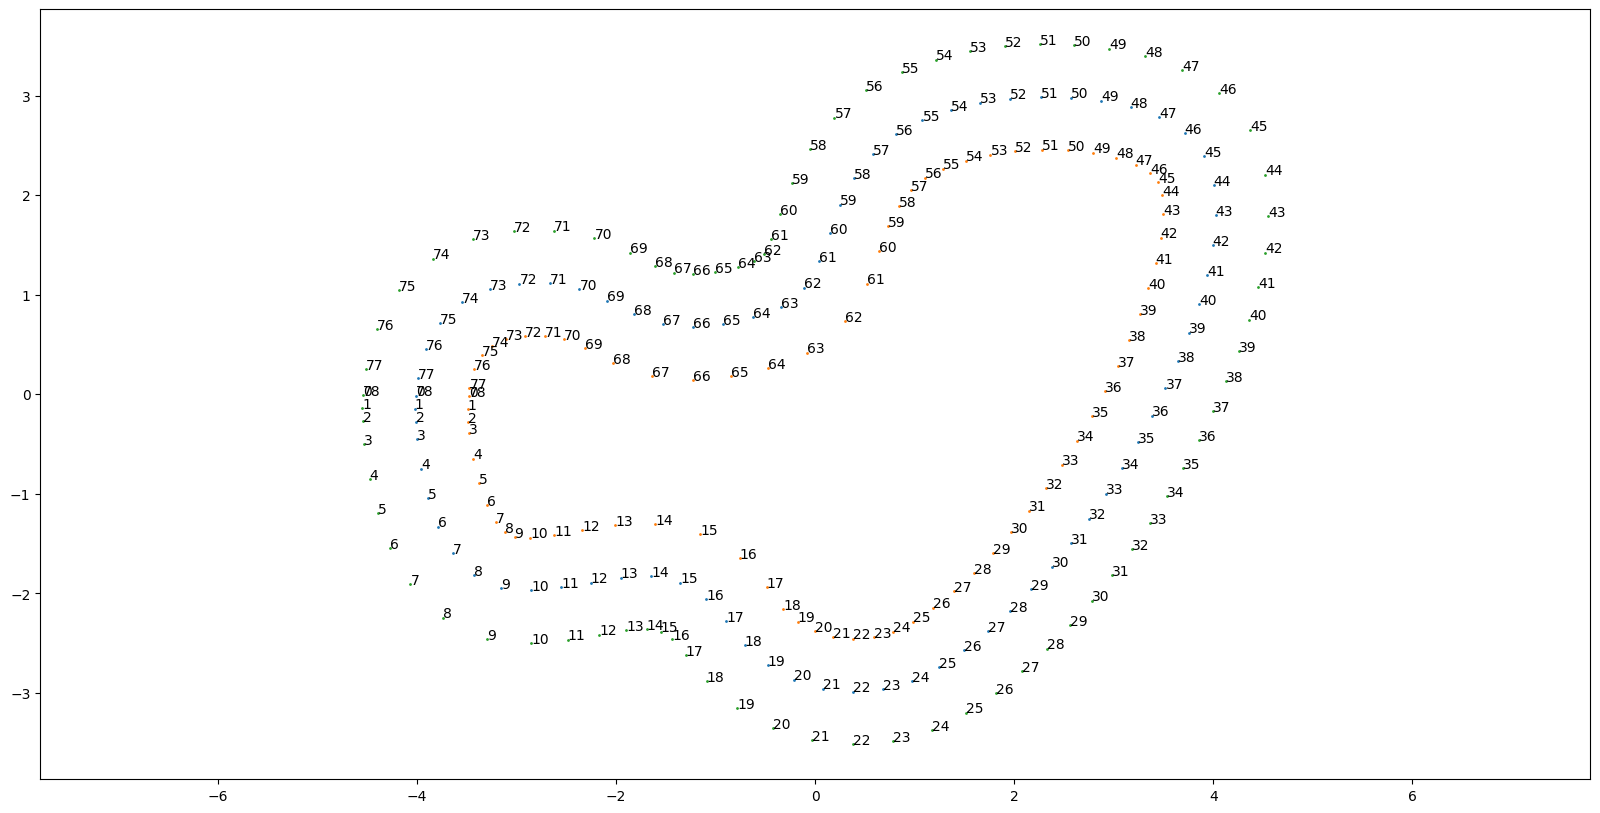

In [3]:
track: Track = tu.load_track(track_name)

l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [4]:
# AWS DeepRacer Console
# fname = 'logs/sample-model/logs/training/training-20230810103618-okmbJfUNS0utbfIMPRxURQ-robomaker.log'

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [5]:
EPISODES_PER_ITERATION = 20  #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(["episode", "steps"])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

# Uncomment the line of code below to evaluate a different reward function
# nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

new reward not found, using reward as its values
Number of episodes =  799
Number of iterations =  40


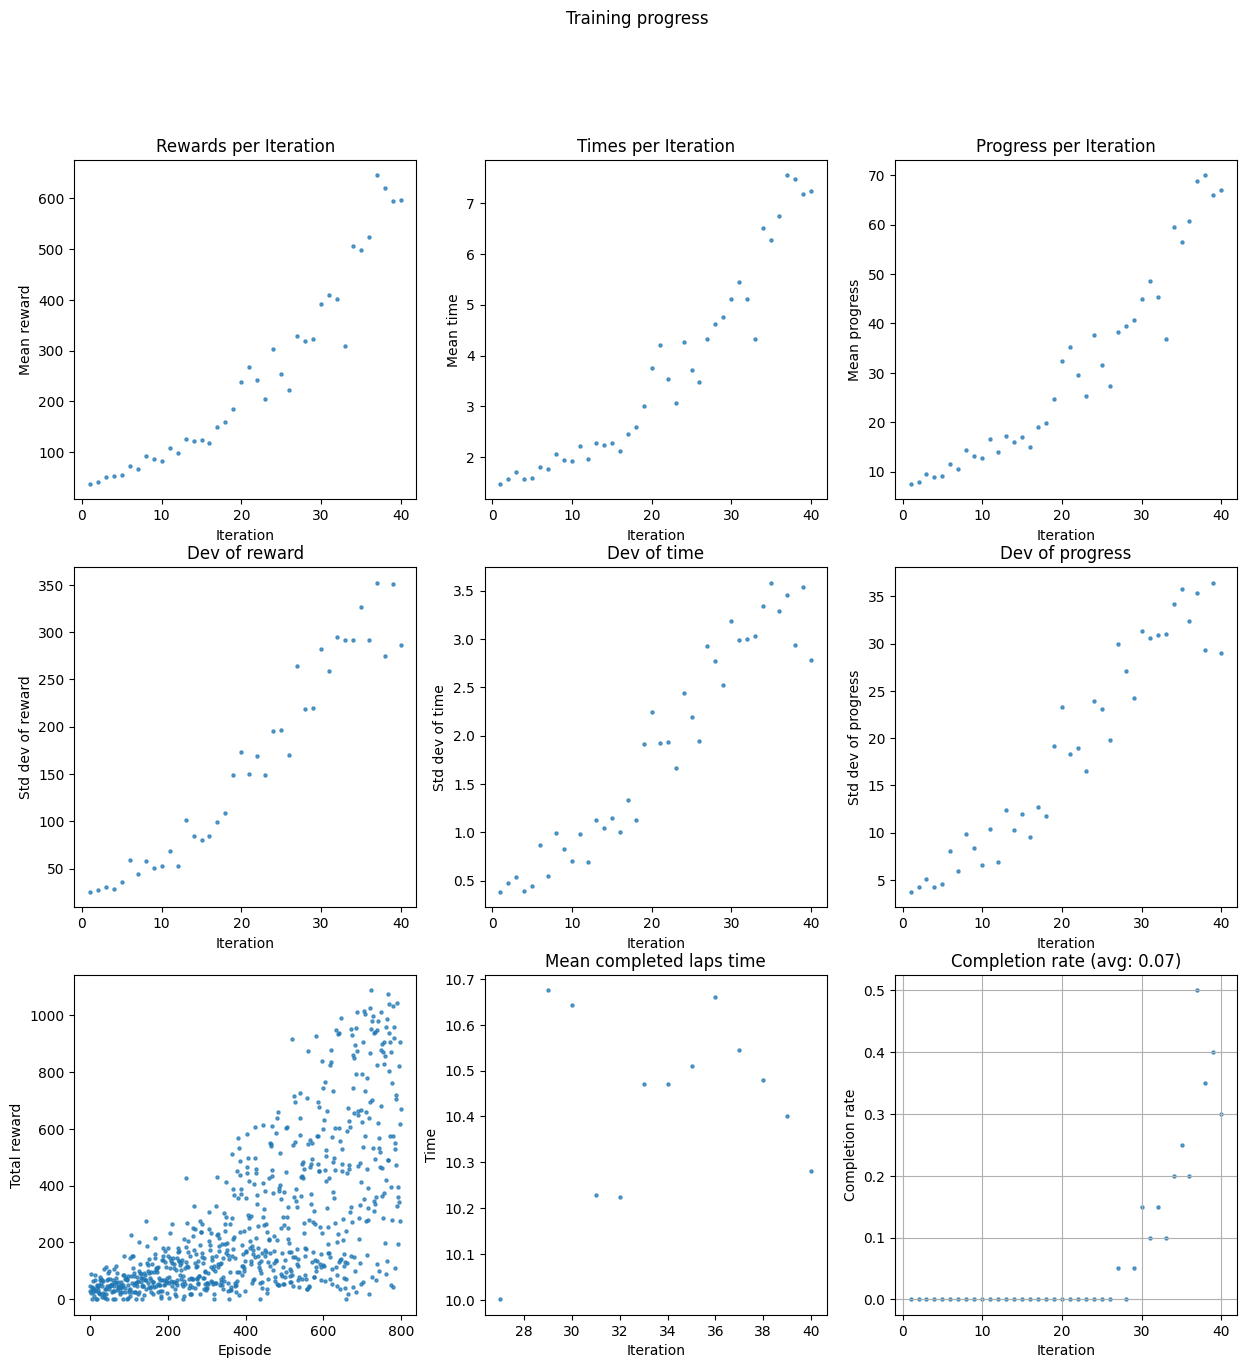

<Figure size 640x480 with 0 Axes>

In [6]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title="Training progress")

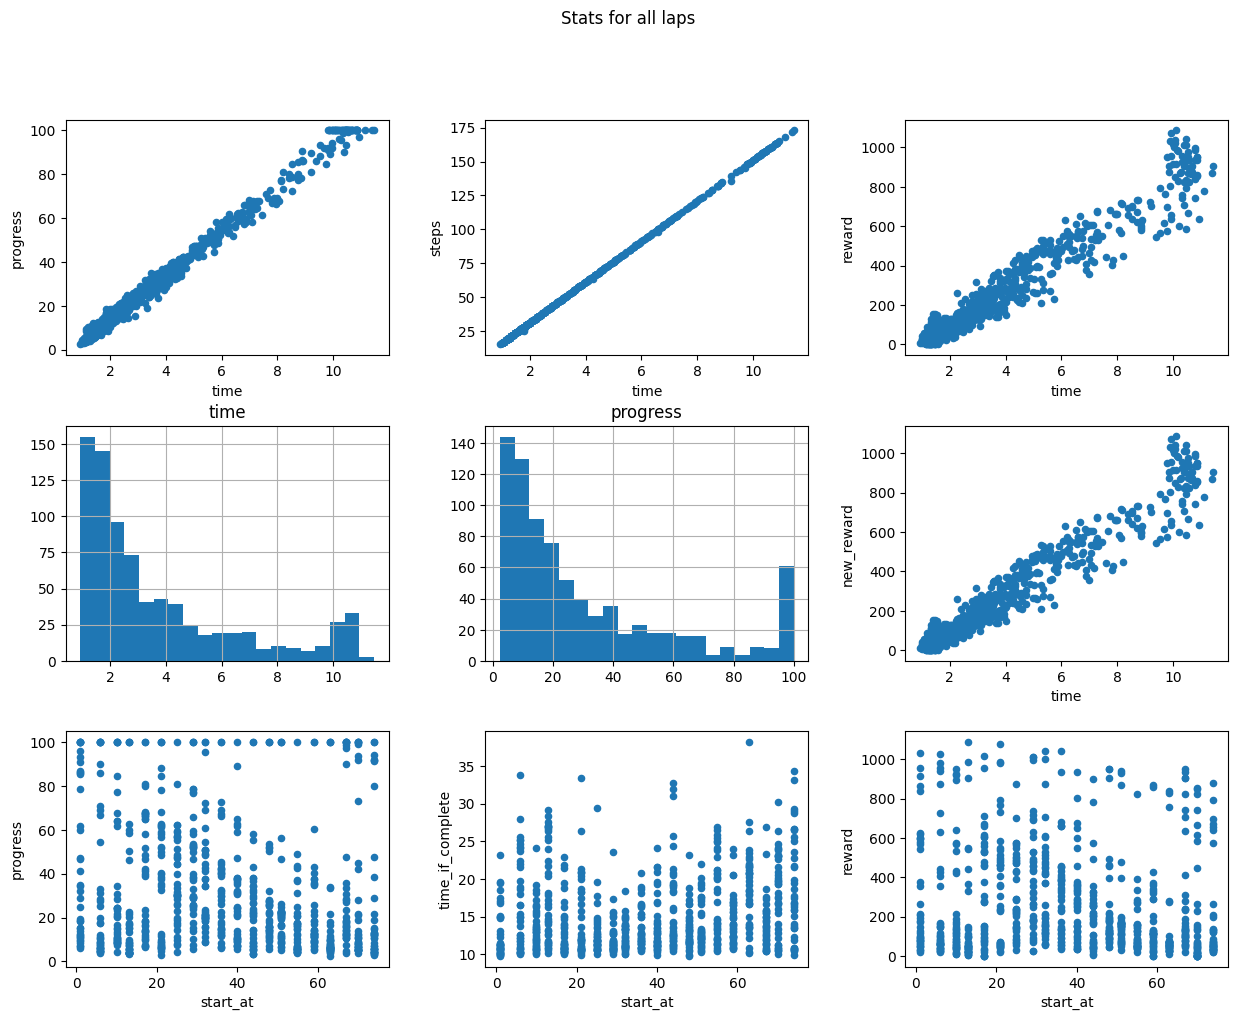

<Figure size 640x480 with 0 Axes>

In [7]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

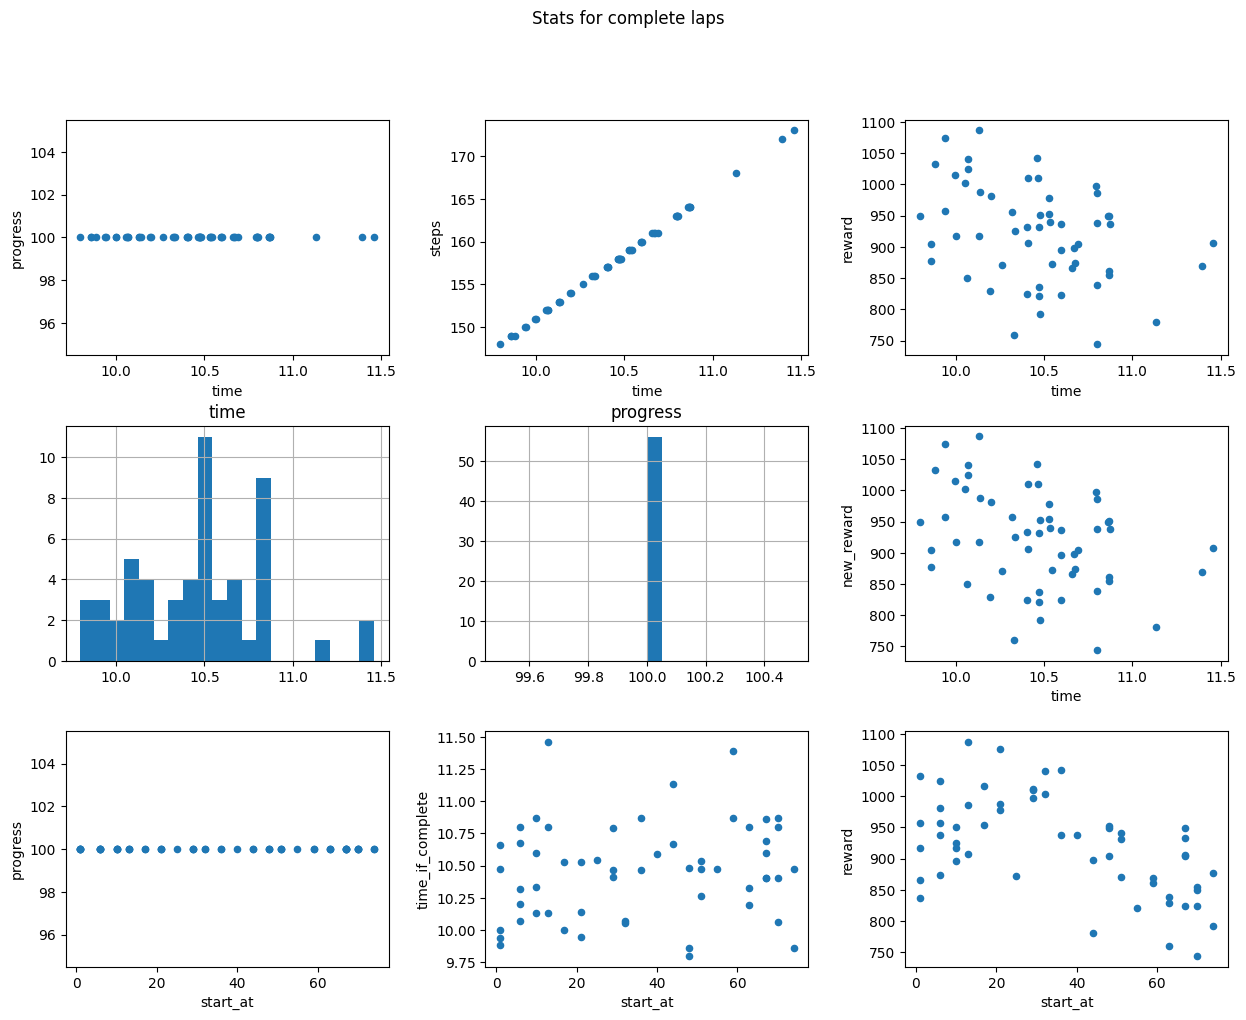

<Figure size 640x480 with 0 Axes>

In [8]:
complete_ones = simulation_agg[simulation_agg["progress"] == 100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, "Stats for complete laps")
else:
    print("No complete laps yet.")

In [9]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

iteration  episode  steps  start_at  progress   time       dist  \
632         32      632    148        48     100.0  9.798  20.743036   
772         39      772    149        48     100.0  9.859  20.637064   
619         31      619    149        74     100.0  9.860  20.746300   
780         40      780    149         1     100.0  9.885  20.079644   
760         39      760    150         1     100.0  9.939  20.523697   

     new_reward     speed     reward  time_if_complete  reward_if_complete  \
632    949.1293  2.277703   949.1293             9.798            949.1293   
772    903.8207  2.251007   903.8207             9.859            903.8207   
619    877.1824  2.236913   877.1824             9.860            877.1824   
780   1032.3581  2.161745  1032.3581             9.885           1032.3581   
760    957.7047  2.210667   957.7047             9.939            957.7047   

    quintile  complete  
632      4th         1  
772      5th         1  
619      4th         1  
780      5th         1  
760      5th         1

In [10]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'reward')

iteration  episode  steps  start_at  progress    time       dist  \
723         37      723    153        13     100.0  10.130  20.671460   
765         39      765    150        21     100.0   9.942  20.296820   
789         40      789    158        36     100.0  10.463  20.025915   
768         39      768    152        32     100.0  10.070  20.082176   
780         40      780    149         1     100.0   9.885  20.079644   

     new_reward     speed     reward  time_if_complete  reward_if_complete  \
723   1086.5965  2.184314  1086.5965            10.130           1086.5965   
765   1074.9145  2.182667  1074.9145             9.942           1074.9145   
789   1042.1213  2.141139  1042.1213            10.463           1042.1213   
768   1040.2388  2.214474  1040.2388            10.070           1040.2388   
780   1032.3581  2.161745  1032.3581             9.885           1032.3581   

    quintile  complete  
723      5th         1  
765      5th         1  
789      5th         1  
768      5th         1  
780      5th         1

In [11]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  episode  steps  start_at  progress    time       dist  \
520         27      520    151         1     100.0  10.001  20.087000   
561         29      561    161         6     100.0  10.675  20.877386   
582         30      582    156        10     100.0  10.334  20.154130   
596         30      596    163        63     100.0  10.800  20.476157   
598         30      598    163        70     100.0  10.799  21.482904   

     new_reward     speed    reward  time_if_complete  reward_if_complete  \
520    917.0939  2.147682  917.0939            10.001            917.0939   
561    873.9734  2.182609  873.9734            10.675            873.9734   
582    924.6936  2.176923  924.6936            10.334            924.6936   
596    839.2714  2.139264  839.2714            10.800            839.2714   
598    743.9080  2.122086  743.9080            10.799            743.9080   

    quintile  complete  
520      4th         1  
561      4th         1  
582      4th         1  
596      4th         1  
598      4th         1

In [12]:
# View information for a couple last episodes
simulation_agg.tail()

iteration  episode  steps  start_at  progress    time       dist  \
795         40      795     71        59   37.3940   4.662   7.834450   
796         40      796     63        63   34.0064   4.138   6.996565   
797         40      797    157        67  100.0000  10.407  20.655355   
798         40      798    146        70   91.8555   9.667  19.316332   
799         40      799    132        74   80.1192   8.730  17.215776   

     new_reward     speed    reward  time_if_complete  reward_if_complete  \
795    342.2183  2.066197  342.2183         12.467241          915.169011   
796    274.8194  2.133333  274.8194         12.168298          808.140232   
797    905.9122  2.178981  905.9122         10.407000          905.912200   
798    617.4085  2.197945  617.4085         10.524138          672.151913   
799    670.9273  2.150000  670.9273         10.896265          837.411382   

    quintile  complete  
795      5th         0  
796      5th         0  
797      5th         1  
798      5th         0  
799      5th         0

In [13]:
one = complete_ones.nsmallest(1, "time")

ITERATION = int(one.iloc[0]["iteration"])
EPISODE = int(one.iloc[0]["episode"])

# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option("display.max_rows", 500)

# View all steps data for episode 10
df[df["episode"] == EPISODE]

iteration  episode  steps       x       y       yaw  steering_angle  \
28261         32      632      1  3.2705  2.8493  159.8548            -8.0   
28262         32      632      2  3.2707  2.8491  159.9025            16.0   
28263         32      632      3  3.2647  2.8519  159.6198           -16.0   
28264         32      632      4  3.2465  2.8561  160.2660             8.0   
28265         32      632      5  3.2112  2.8683  160.5681             8.0   
28266         32      632      6  3.1588  2.8799  162.0001            16.0   
28267         32      632      7  3.1021  2.8865  164.4619             0.0   
28268         32      632      8  3.0272  2.9005  166.1875             8.0   
28269         32      632      9  2.9407  2.9179  166.9592             8.0   
28270         32      632     10  2.8414  2.9321  168.7678             8.0   
28271         32      632     11  2.7260  2.9446  170.7861             8.0   
28272         32      632     12  2.6052  2.9505  173.5033             8.0   
28273         32      632     13  2.4612  2.9514  176.4927             8.0   
28274         32      632     14  2.3763  2.9490  178.2047            16.0   
28275         32      632     15  2.2429  2.9354 -178.1650             8.0   
28276         32      632     16  2.1034  2.9072 -173.3098             8.0   
28277         32      632     17  1.9810  2.8737 -169.4486            16.0   
28278         32      632     18  1.8419  2.8217 -164.3452            16.0   
28279         32      632     19  1.7320  2.7643 -158.8906            16.0   
28280         32      632     20  1.6141  2.6916 -153.6391            -8.0   
28281         32      632     21  1.4497  2.5894 -150.4216             0.0   
28282         32      632     22  1.3375  2.5332 -151.7747           -16.0   
28283         32      632     23  1.1868  2.4699 -154.8407             8.0   
28284         32      632     24  1.0456  2.4104 -156.2298             0.0   
28285         32      632     25  0.8896  2.3371 -155.3698             8.0   
28286         32      632     26  0.7426  2.2588 -153.3724             8.0   
28287         32      632     27  0.5813  2.1537 -148.9911             8.0   
28288         32      632     28  0.4277  2.0351 -144.2675            16.0   
28289         32      632     29  0.2602  1.8825 -139.2967            16.0   
28290         32      632     30  0.1413  1.7610 -136.4108            -8.0   
28291         32      632     31 -0.0024  1.6091 -133.0234           -16.0   
28292         32      632     32 -0.1438  1.4777 -134.0227           -16.0   
28293         32      632     33 -0.2807  1.3733 -138.9083           -16.0   
28294         32      632     34 -0.4228  1.2801 -143.8130            -8.0   
28295         32      632     35 -0.5733  1.1957 -147.8931           -16.0   
28296         32      632     36 -0.7104  1.1306 -151.4608            -8.0   
28297         32      632     37 -0.8429  1.0789 -155.0858            -8.0   
28298         32      632     38 -1.0090  1.0275 -159.5762            -8.0   
28299         32      632     39 -1.1743  0.9895 -163.8893            -8.0   
28300         32      632     40 -1.3323  0.9641 -167.7355            -8.0   
28301         32      632     41 -1.4985  0.9497 -171.8721           -24.0   
28302         32      632     42 -1.6682  0.9452 -175.6699           -24.0   
28303         32      632     43 -1.7894  0.9506 -178.7196            -8.0   
28304         32      632     44 -1.9414  0.9680  177.1381             8.0   
28305         32      632     45 -2.0899  0.9882  174.7401            16.0   
28306         32      632     46 -2.2539  0.9946  176.4532             8.0   
28307         32      632     47 -2.4089  0.9869  179.8422             8.0   
28308         32      632     48 -2.5639  0.9717 -176.9117            16.0   
28309         32      632     49 -2.7204  0.9371 -170.9296             8.0   
28310         32      632     50 -2.8692  0.8942 -166.8291            16.0   
28311         32      632    

# Extract Action Space List from LOG file

In [14]:
# Extract Action Space List
dgr_norm = 1  # for degrees

if df["steering_angle"].max() < 2:
    dgr_norm = 57.6923  # for radians


class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0, 0, 0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle  # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color


maxThrottle = df.speed.max()

# AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steering_angle','speed'].median()
AS = df[df["steps"] != 0].groupby(["action"], as_index=False)[["steering_angle", "speed"]].median()

asl = [None] * AS.shape[0]
for i in range(0, AS.shape[0]):
    j = AS.action[i].astype(int)
    # asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steering_angle[i] * dgr_norm, 2), round(AS.speed[i], 2))
    asl[j].rel_thr = AS.speed[i] / maxThrottle

    cr = 8 * max(0, np.sign(asl[j].steer)) * abs(asl[j].steer) / 255
    cg = (0 + 6 * (30 - abs(asl[j].steer))) / 255
    cb = -8 * min(0, np.sign(asl[j].steer)) * abs(asl[j].steer) / 255

    asl[AS.action[i].astype(int)].color = [cr, cg, cb]

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:, 0]) - trkFrame
trkPlotXmax = max(l_outer_border[:, 0]) + trkFrame
trkPlotYmin = min(l_outer_border[:, 1]) - trkFrame
trkPlotYmax = max(l_outer_border[:, 1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

# print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steering_angle.min() * dgr_norm, 2)
asPlotXmax = round(df.steering_angle.max() * dgr_norm, 2)
asPlotYmin = round(df.speed.min(), 2)
asPlotYmax = round(df.speed.max(), 2)

# df.throttle.min()
# print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl:
    print(obj.index, obj.steer, obj.throttle, sep="\t\t")

Actions: 
index		steering	throttle
0		-30.0		1.1
1		-24.0		1.1
2		-24.0		1.8
3		-24.0		2.5
4		-16.0		1.1
5		-16.0		1.8
6		-16.0		2.5
7		-16.0		3.2
8		-8.0		1.1
9		-8.0		1.8
10		-8.0		2.5
11		-8.0		3.2
12		-8.0		3.9
13		0.0		3.9
14		0.0		3.2
15		0.0		2.5
16		0.0		1.8
17		8.0		3.9
18		8.0		3.2
19		8.0		2.5
20		8.0		1.8
21		8.0		1.1
22		16.0		3.2
23		16.0		2.5
24		16.0		1.8
25		16.0		1.1
26		24.0		2.5
27		24.0		1.8
28		24.0		1.1
29		30.0		1.1


## Function definitions

In [15]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N = 100
        ax.set_title("Action Index Map")
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel="Steering", ylabel="Speed", xlim=(35, -35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle), color=obj.color, s=1200 * obj.rel_thr, alpha=0.85)
        ax.text(
            (0.5 - obj.steer / 70),
            (0.0 + obj.throttle / asMaxY),
            obj.index,
            verticalalignment="center",
            horizontalalignment="center",
            transform=ax.transAxes,
            color="w",
            fontsize=15,
        )
    plt.show()


### Action space histograms


# 4 in 1 Histograms
def plot_4_hist(df, itr=-1, E=-1):
    if itr > -1:
        episode_data = df[df["iteration"] == itr]
        print("Histograms for iteration:", itr)
    else:
        if E > -1:
            episode_data = df[df["episode"] == E]
            print("Histograms for episode:", E)
        else:
            episode_data = df[:]
            print("Histograms for all episodes:")
    fig, axs = plt.subplots(2, 2, sharex="col", figsize=(14, 10), sharey="row", gridspec_kw={"hspace": 0, "wspace": 0})
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data["steering_angle"] * (dgr_norm), episode_data["speed"], bins=(63, 56), range=[[-31, 31], [0, asMaxY]])
    ax3.set(xlabel="Steering", ylabel="Speed", xlim=(31, -31))
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data["steering_angle"] * (dgr_norm / 57.6923), episode_data["speed"], bins=(90, 23), range=[[-1.57, 1.57], [0, asMaxY]])
    # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data["steering_angle"] * dgr_norm, bins=60)
    ax4.hist(episode_data["speed"], bins=50, orientation="horizontal")  # steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()


## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1, E=-1):
    if itr > -1:
        episode_data = df[df["iteration"] == itr]
        print("Histograms for iteration:", itr)
    else:
        if E > -1:
            episode_data = df[df["episode"] == E]
            print("Histograms for episode:", E)
        else:
            episode_data = df[:]
            print("Histogram for all episodes:")
    fig2 = plt.figure(1, figsize=(7, 7))
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data["steering_angle"] * (dgr_norm / 57.6923), episode_data["speed"], bins=(90, 25), range=[[-1.57, 1.57], [0, asMaxY]])


## Ploting steps in the episodes with red dots
def plot_episode_red(df, E):  # , center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX / 5, trkSizeY / 5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke")  # center_line, inner_border, outer_border)
    episode_data = df[df["episode"] == E]
    for row in episode_data.iterrows():
        x1, y1, action, reward = row[1]["x"], row[1]["y"], row[1]["action"], row[1]["reward"]
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], "r.")


## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E):  # , center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX / 5, trkSizeY / 5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke")  # center_line, inner_border, outer_border)
    episode_data = df[df["episode"] == E]
    for row in episode_data.iterrows():
        x1, y1, action, reward = row[1]["x"], row[1]["y"], row[1]["action"], row[1]["reward"]
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle) ** 2 * 50  # tune the size of the dots
        # print(action_color)
        # plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

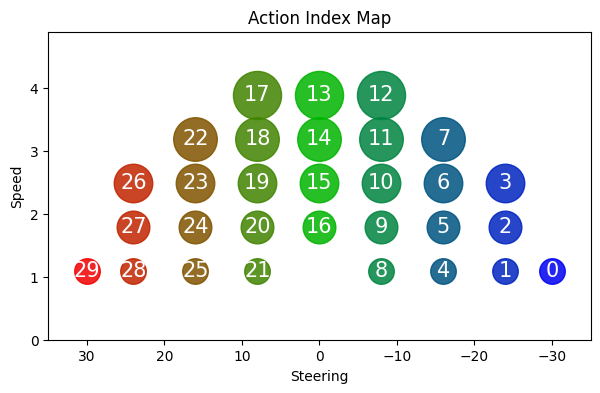

In [16]:
plot_index_map(asl)    

# Analysing data from all episodes

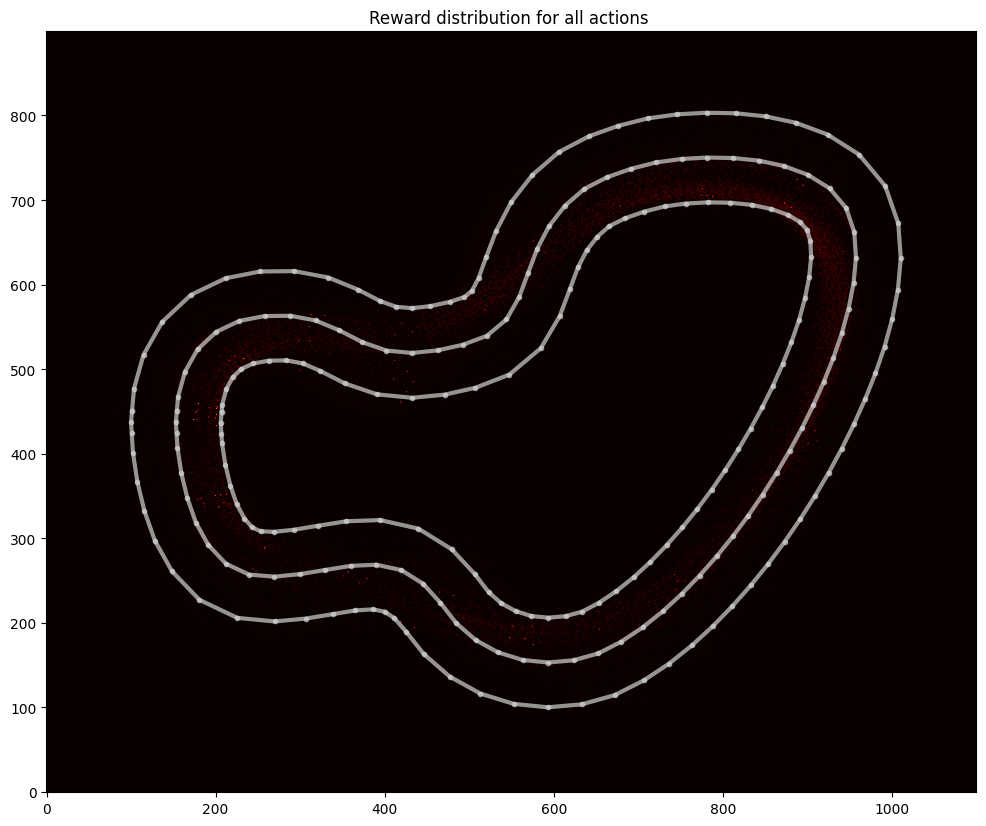

<Figure size 640x480 with 0 Axes>

In [17]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


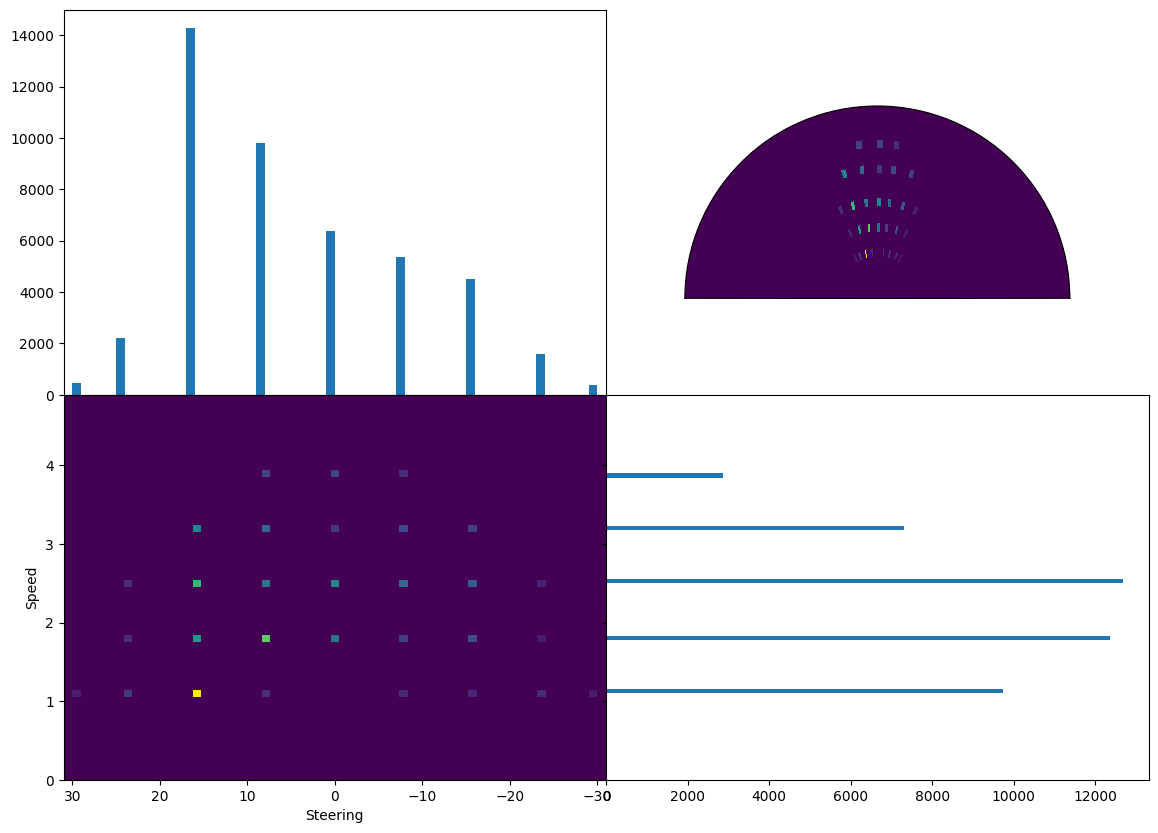

In [18]:
plot_4_hist(df)

Histogram for all episodes:


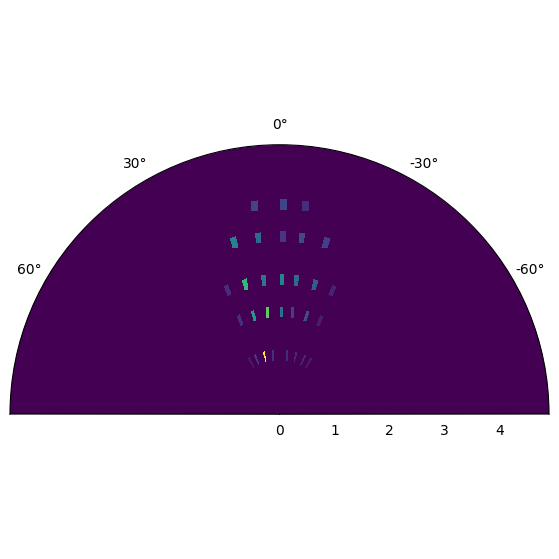

In [19]:
plot_polar_hist(df)



# Analyzing specific iteration





In [20]:
# Set iteration id
itr = ITERATION                        # iteration id
# itr = df['iteration'].max() - 5  # last iteration

Iteration: 32


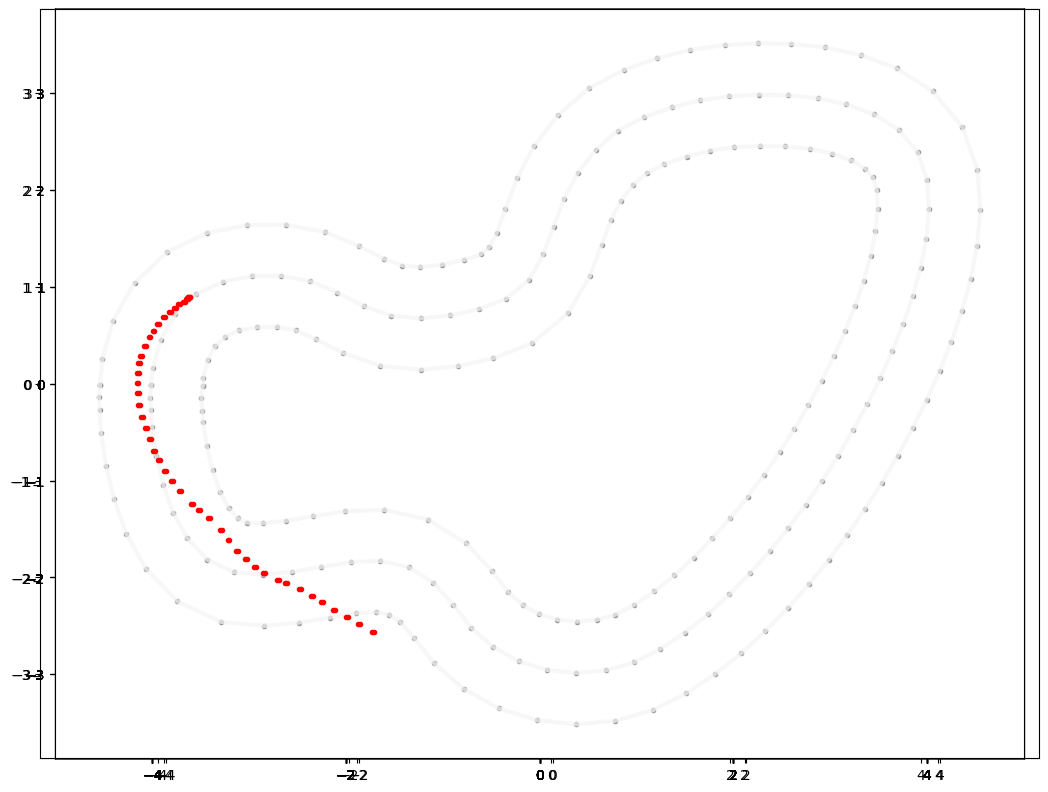

In [21]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)

Histograms for iteration: 32


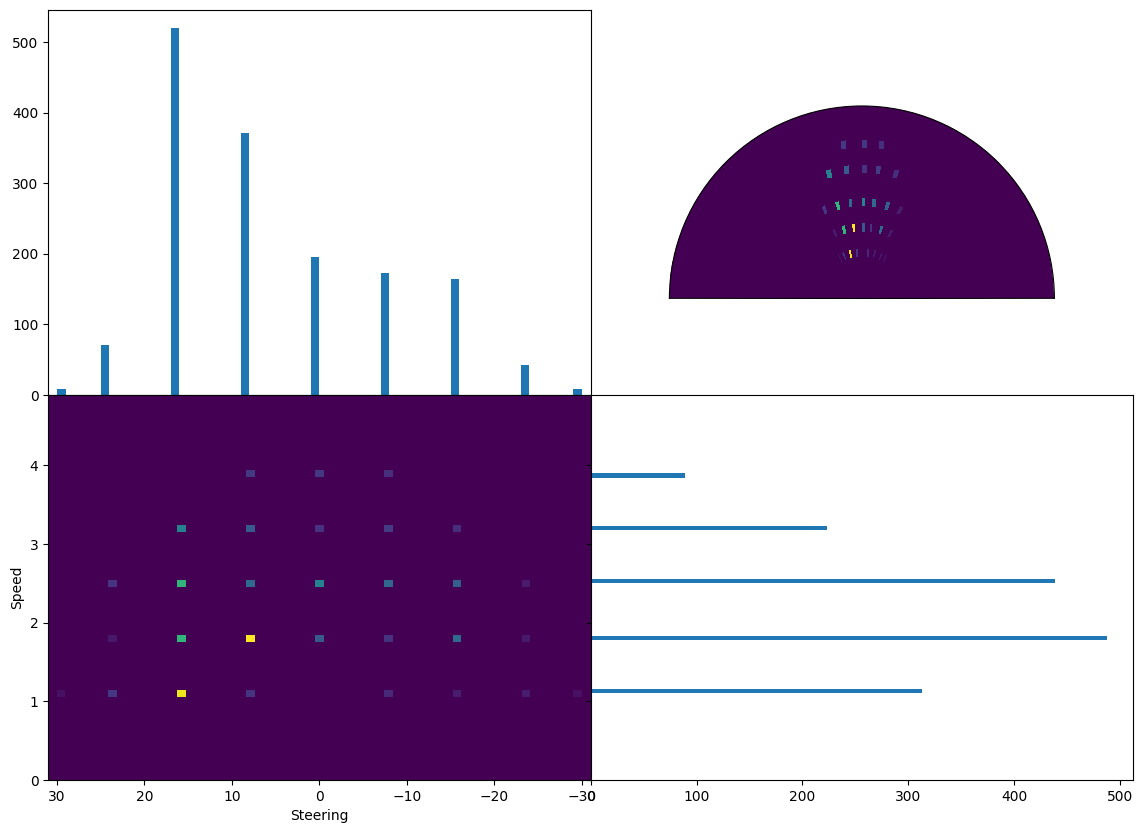

In [22]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 32


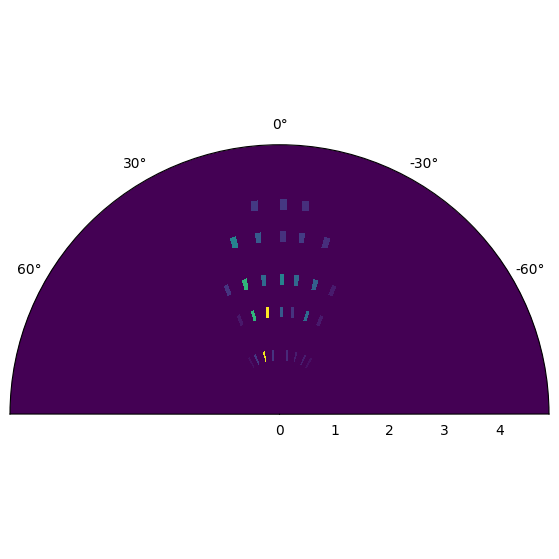

In [23]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [24]:
### choose episode id
EPZ = EPISODE

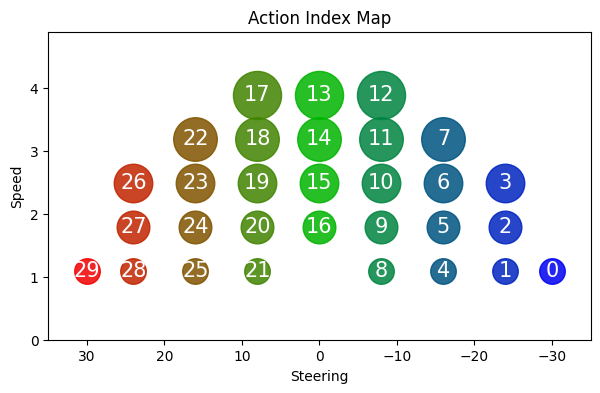

In [25]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


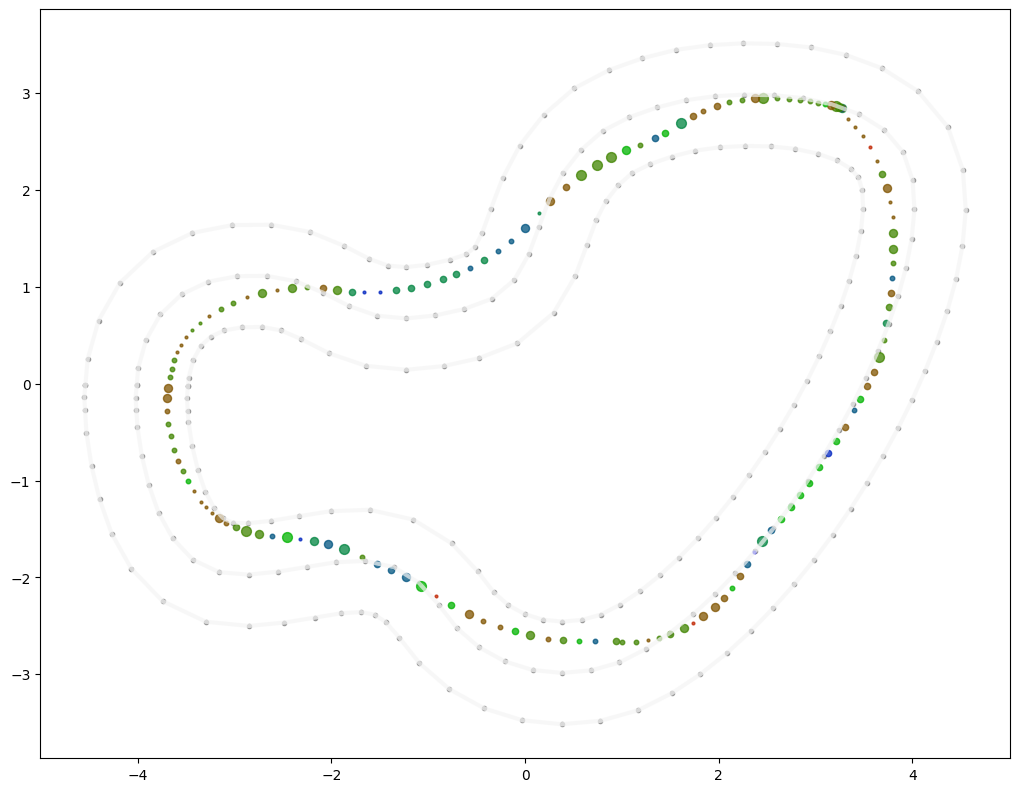

In [26]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 632


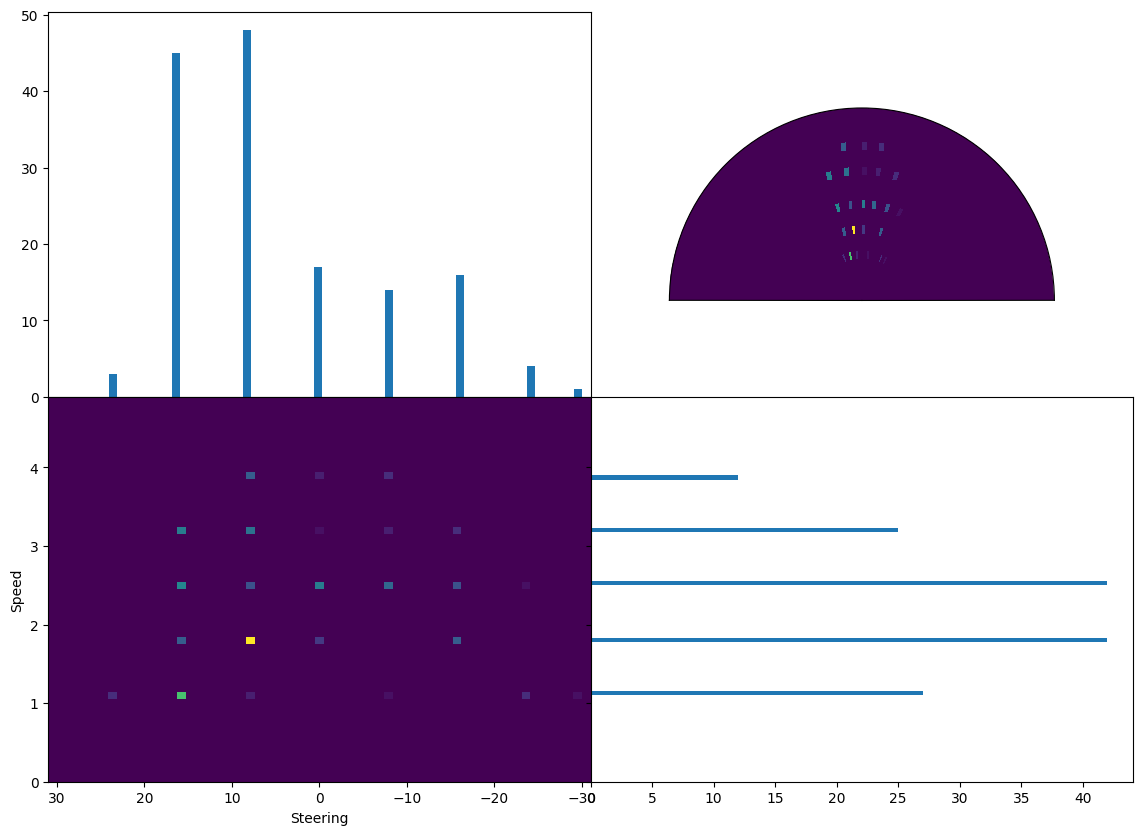

In [27]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 632


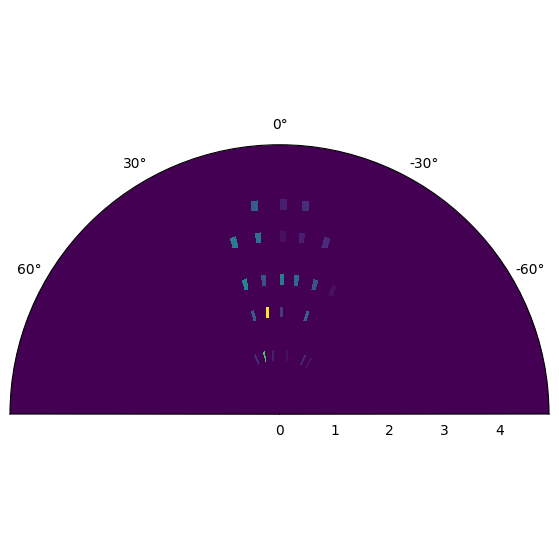

In [28]:
plot_polar_hist(df, E = EPZ)

<AxesSubplot: xlabel='closest_waypoint'>

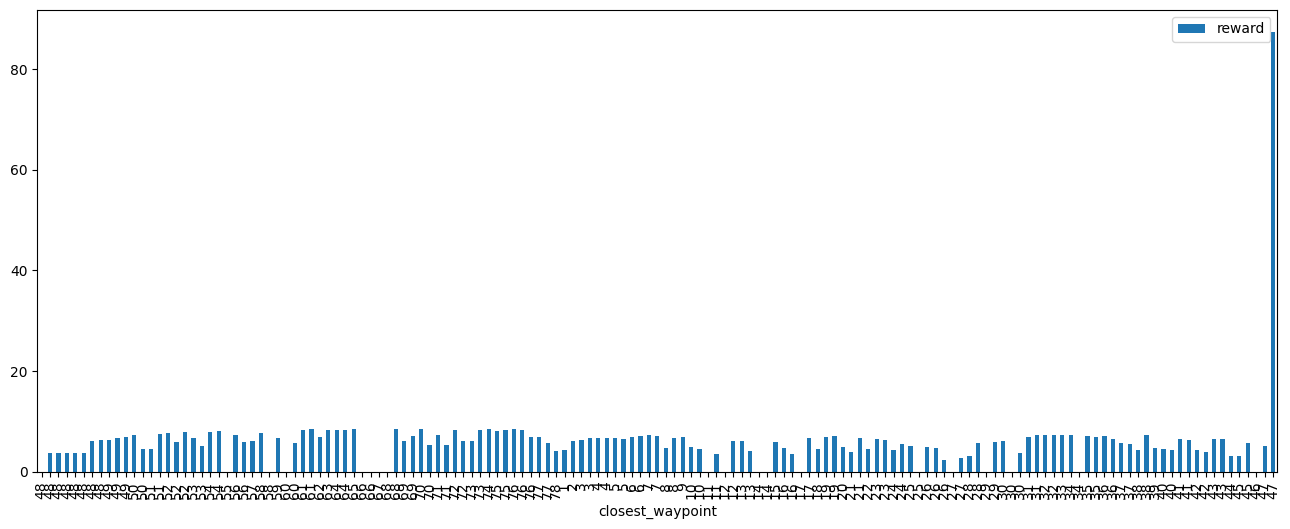

In [29]:
# This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df["episode"] == EPZ]
episode[:-1].plot.bar(x="closest_waypoint", y="reward", figsize=(16, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.1


<Figure size 640x480 with 0 Axes>

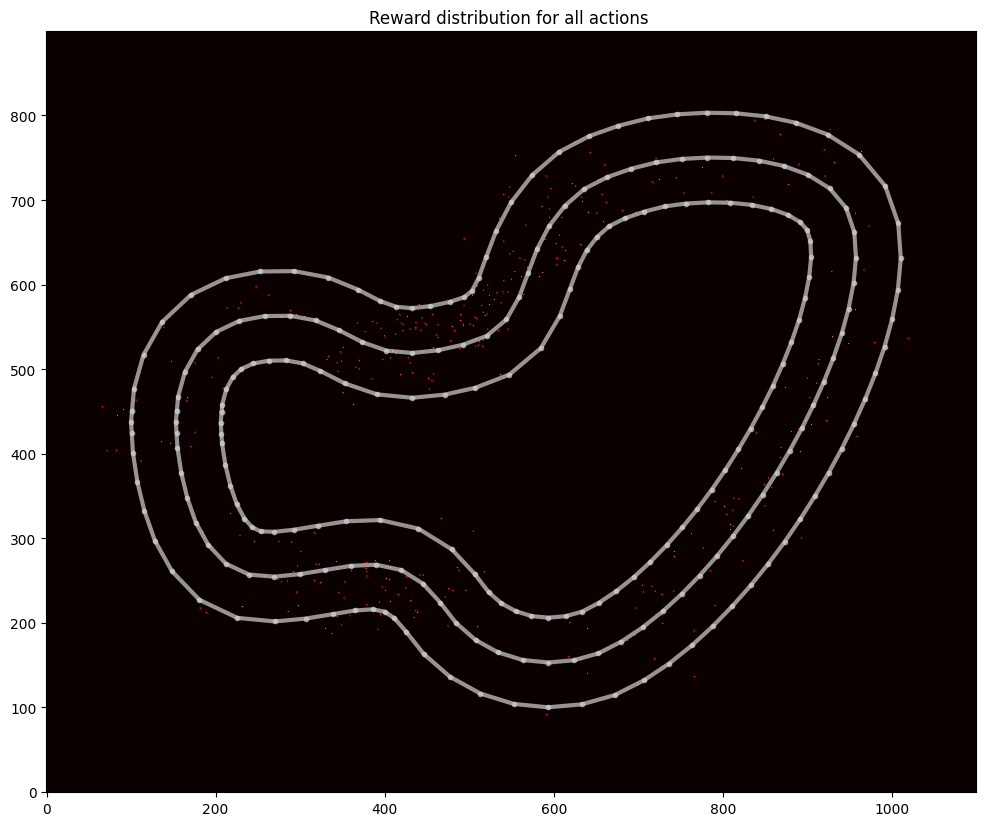

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 1: steering: -24.0, throttle: 1.1


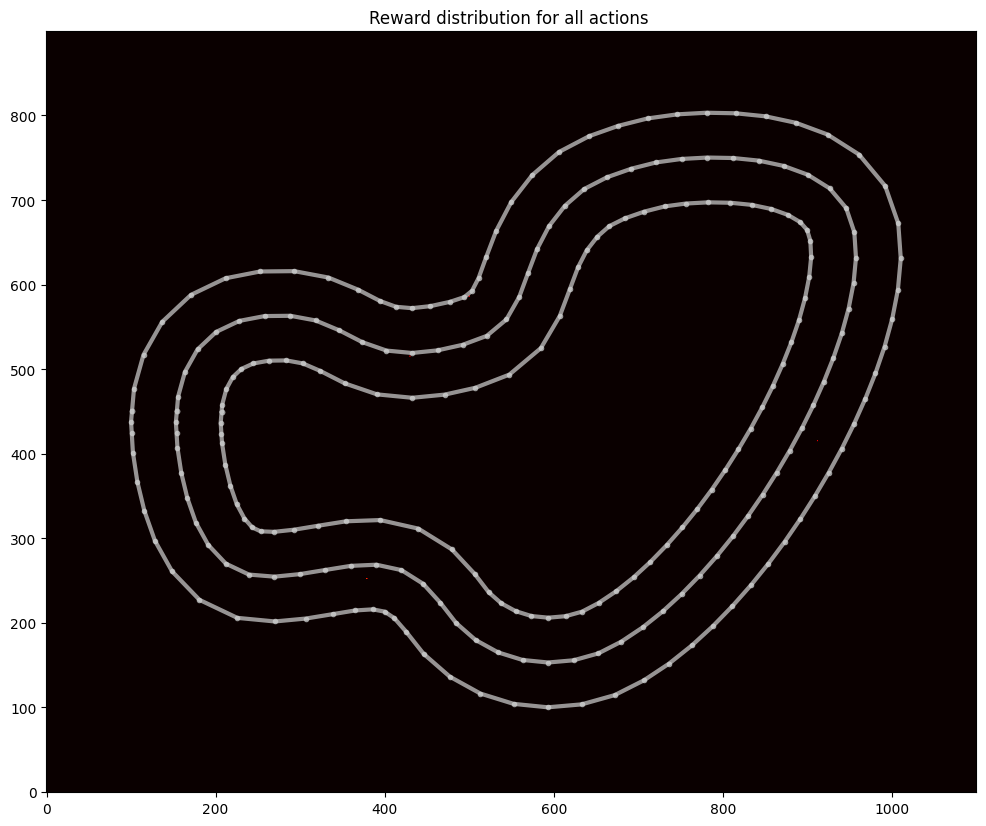

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 2: steering: -24.0, throttle: 1.8


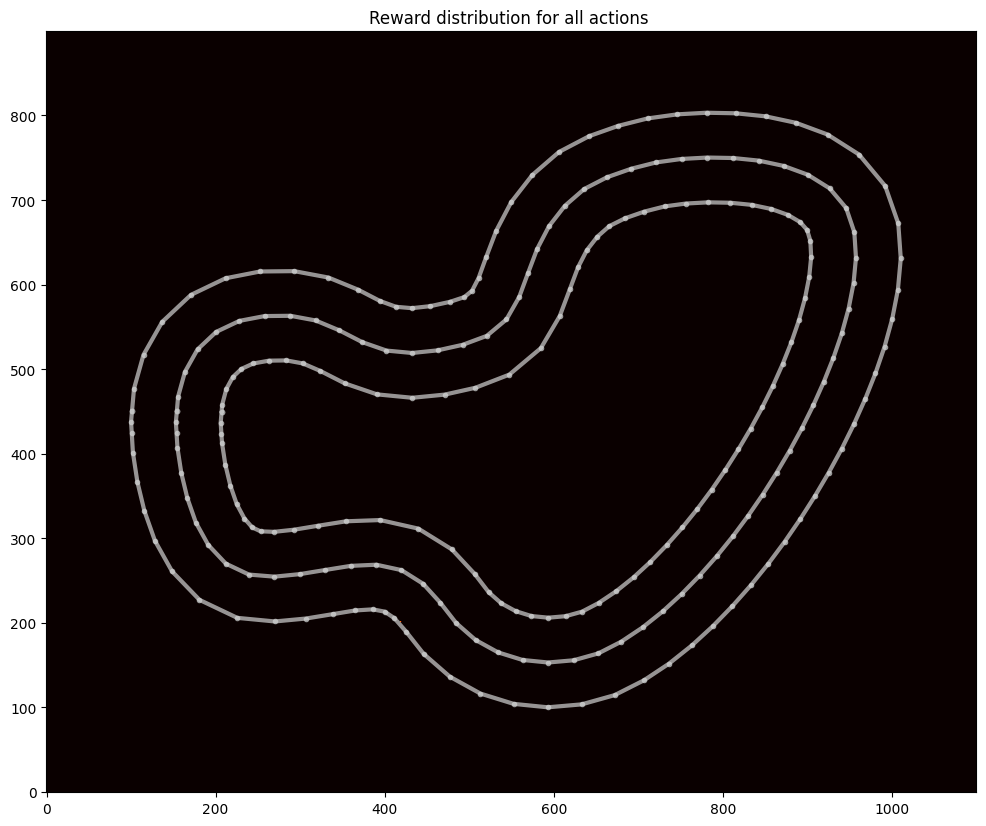

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 3: steering: -24.0, throttle: 2.5


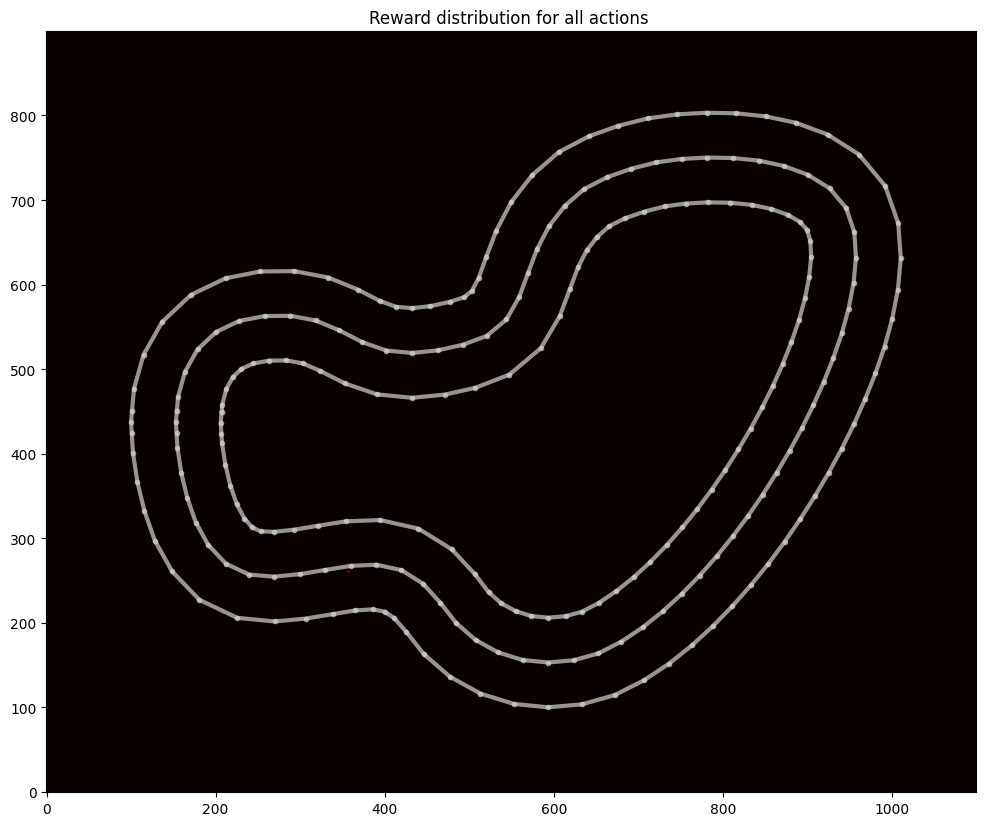

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 4: steering: -16.0, throttle: 1.1


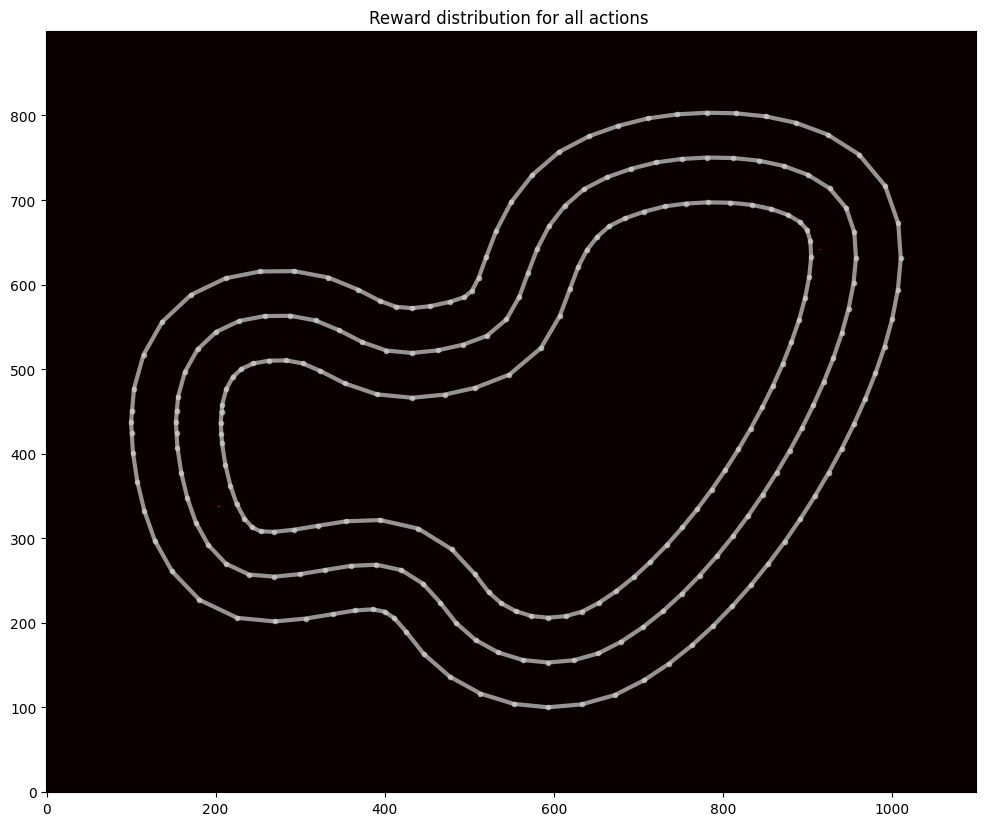

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 5: steering: -16.0, throttle: 1.8


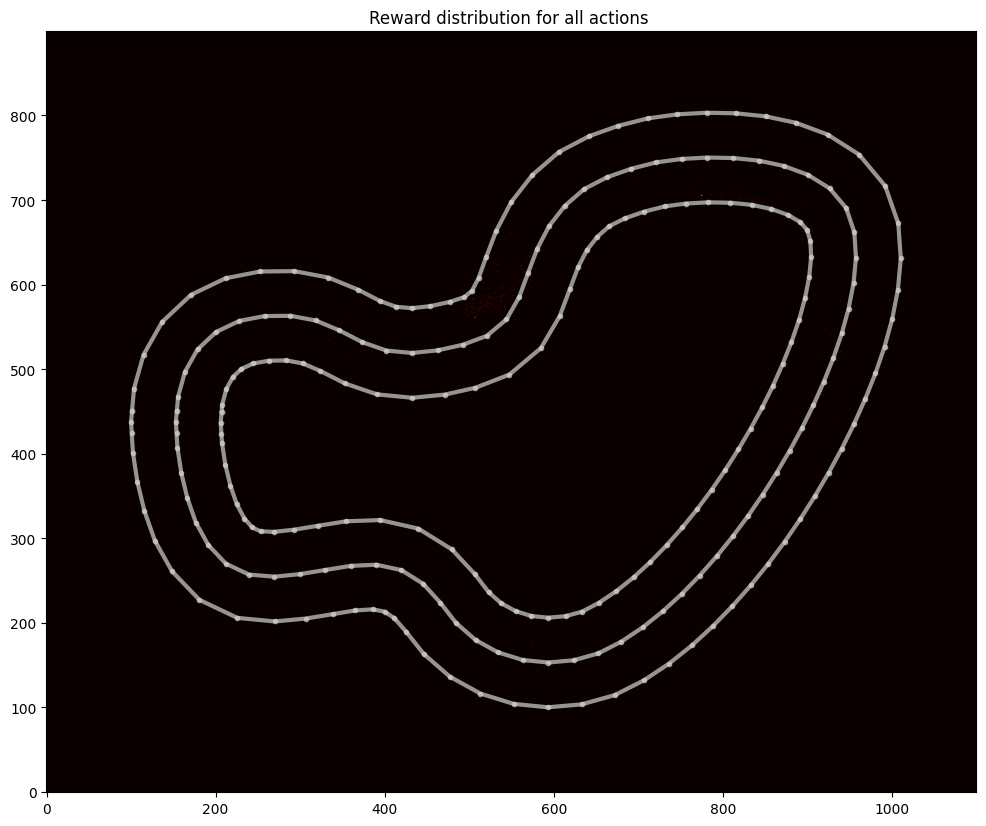

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 6: steering: -16.0, throttle: 2.5


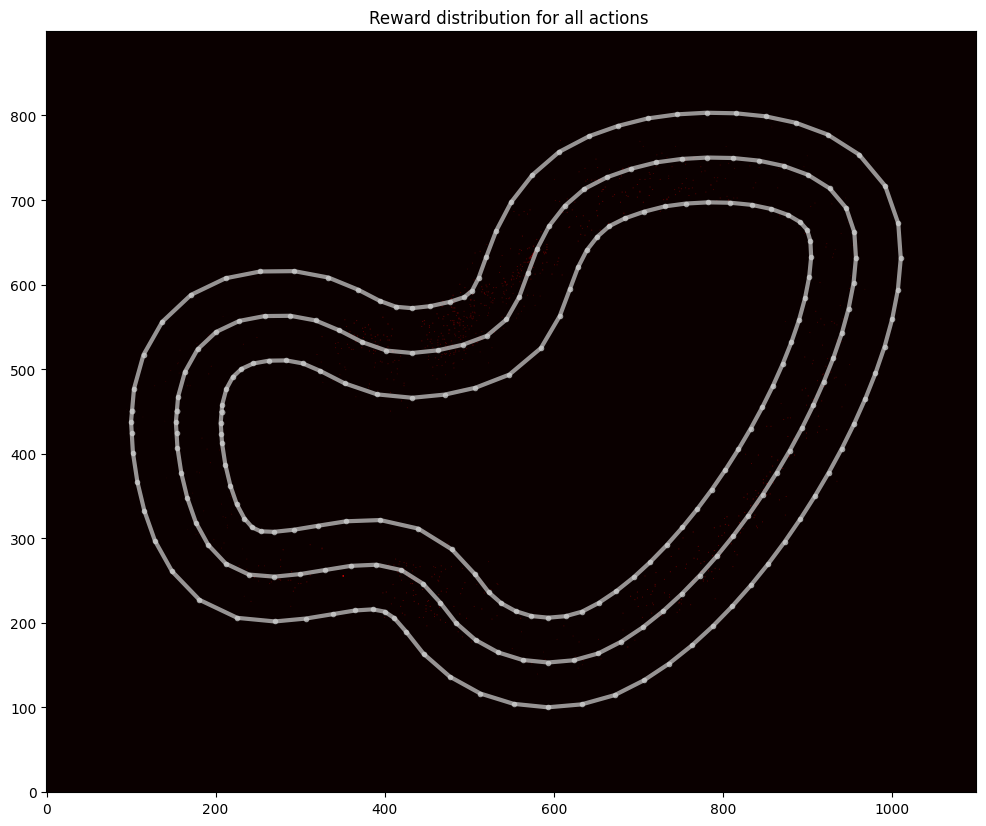

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 7: steering: -16.0, throttle: 3.2


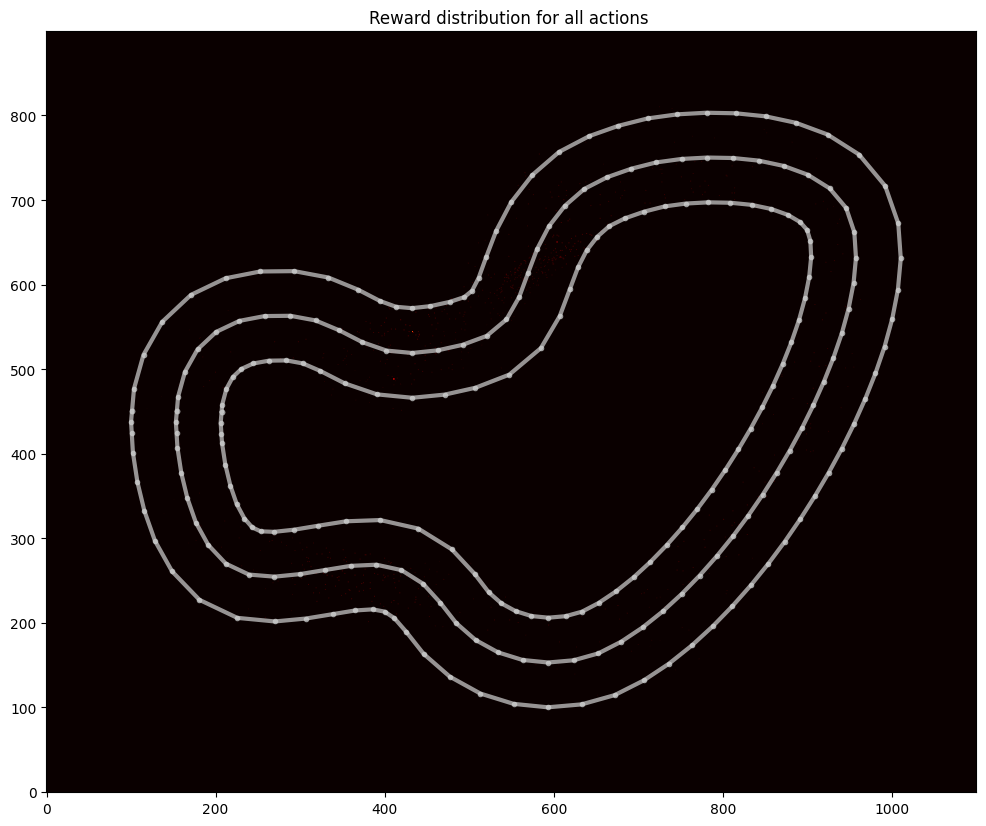

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 8: steering: -8.0, throttle: 1.1


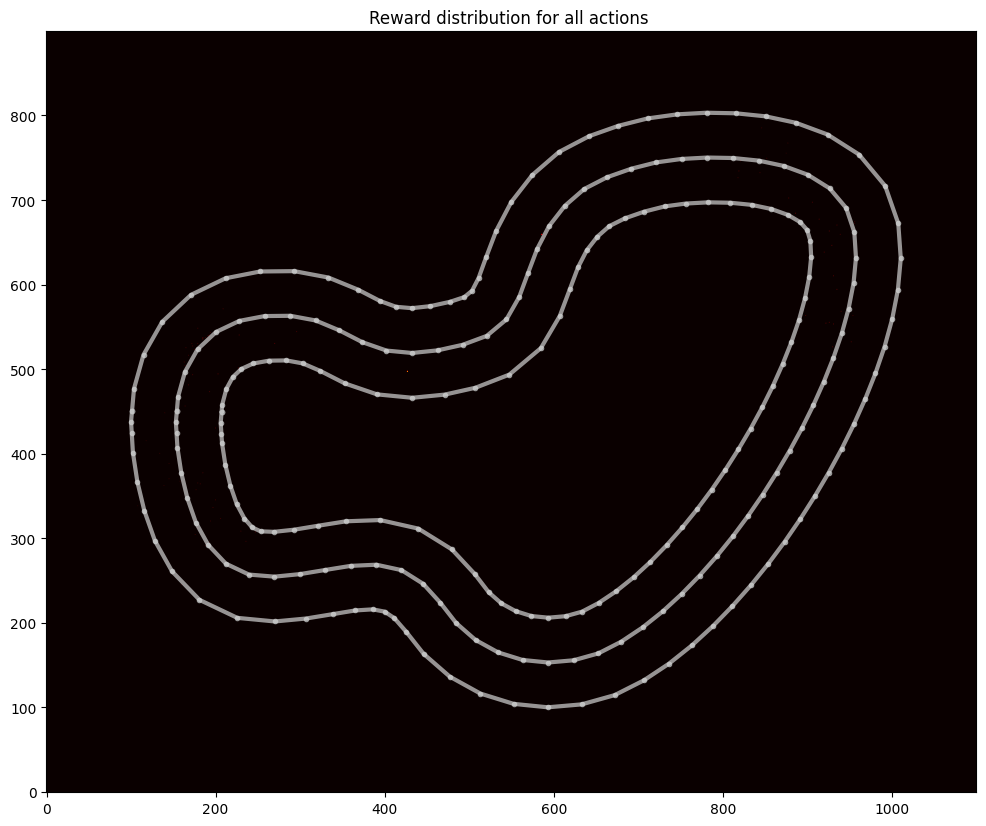

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 9: steering: -8.0, throttle: 1.8


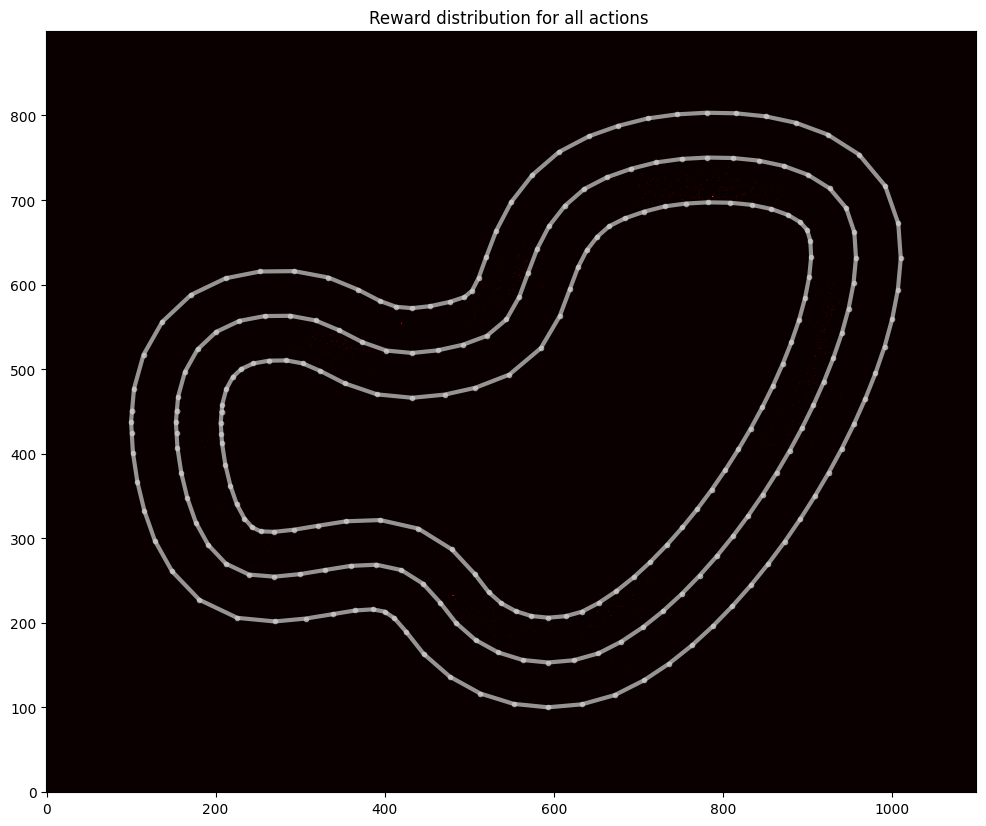

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 10: steering: -8.0, throttle: 2.5


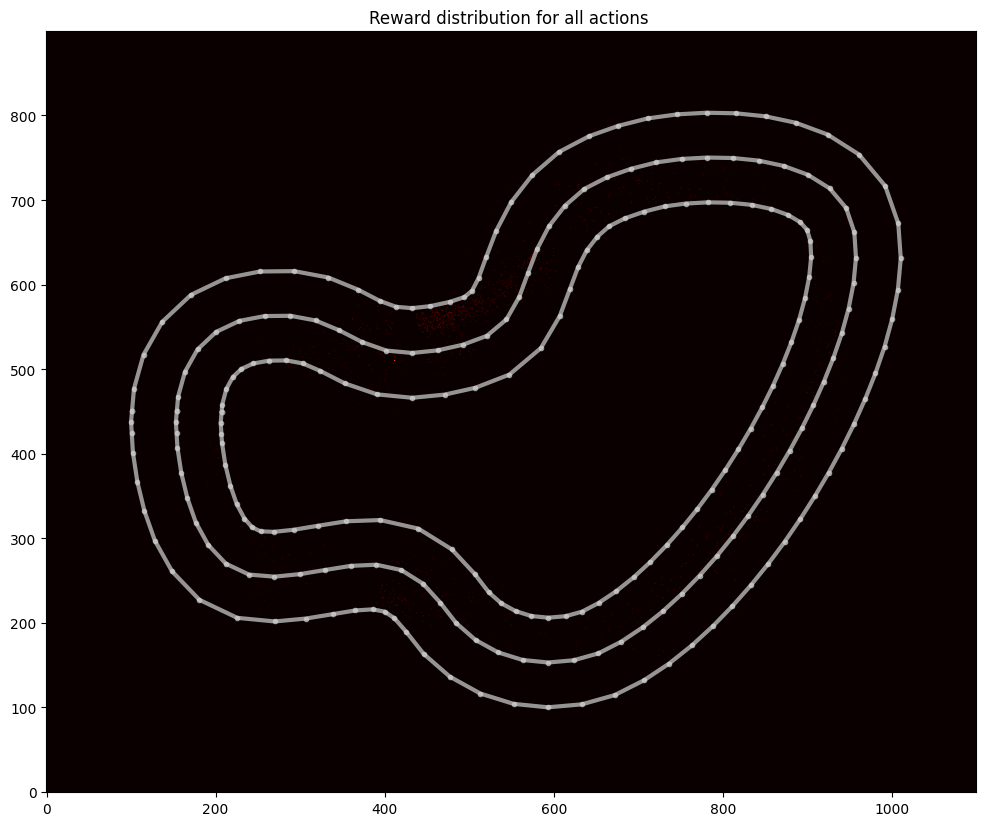

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 11: steering: -8.0, throttle: 3.2


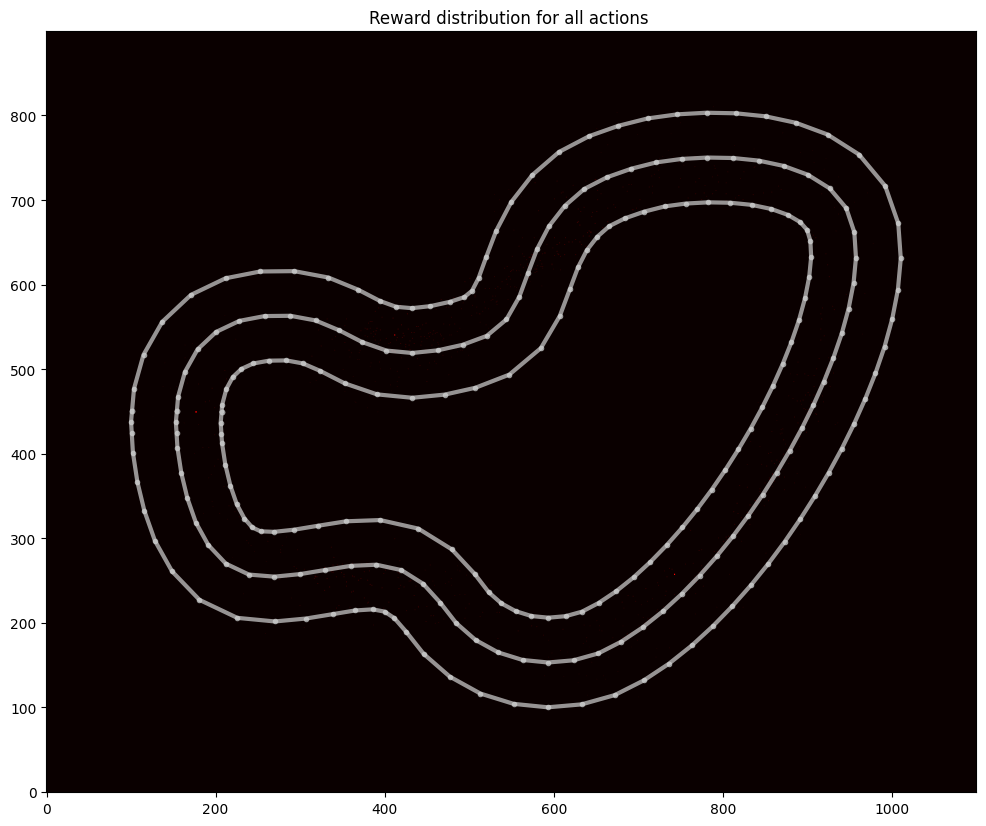

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 12: steering: -8.0, throttle: 3.9


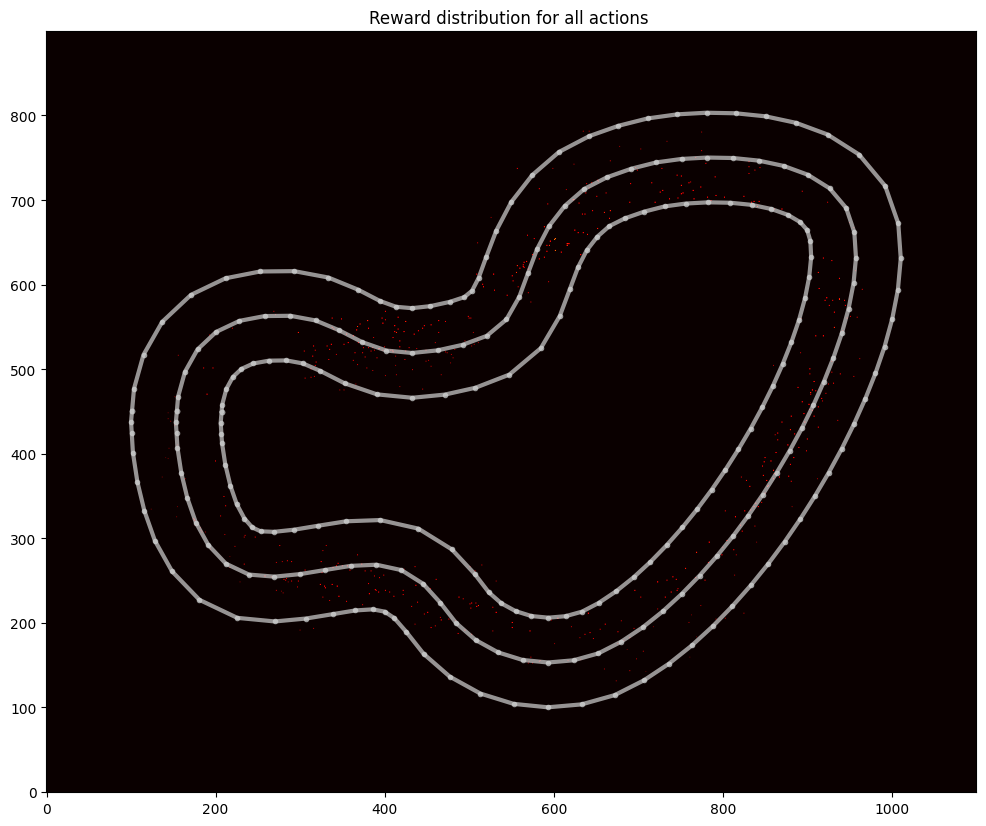

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 13: steering: 0.0, throttle: 3.9


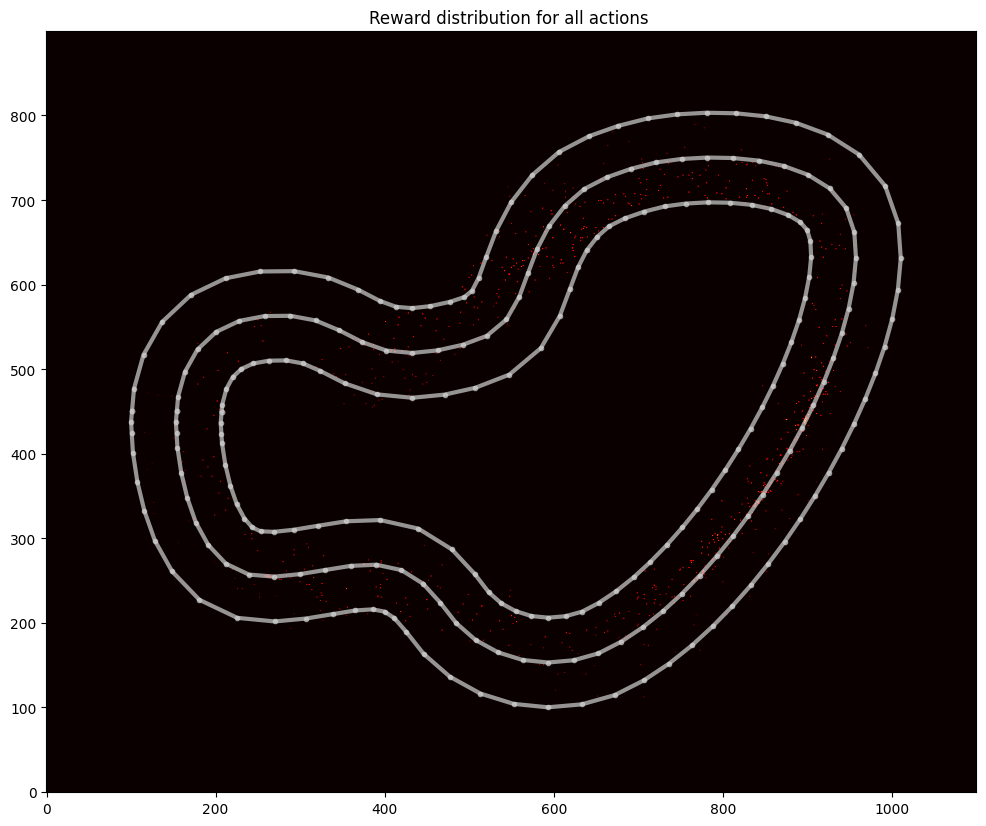

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 14: steering: 0.0, throttle: 3.2


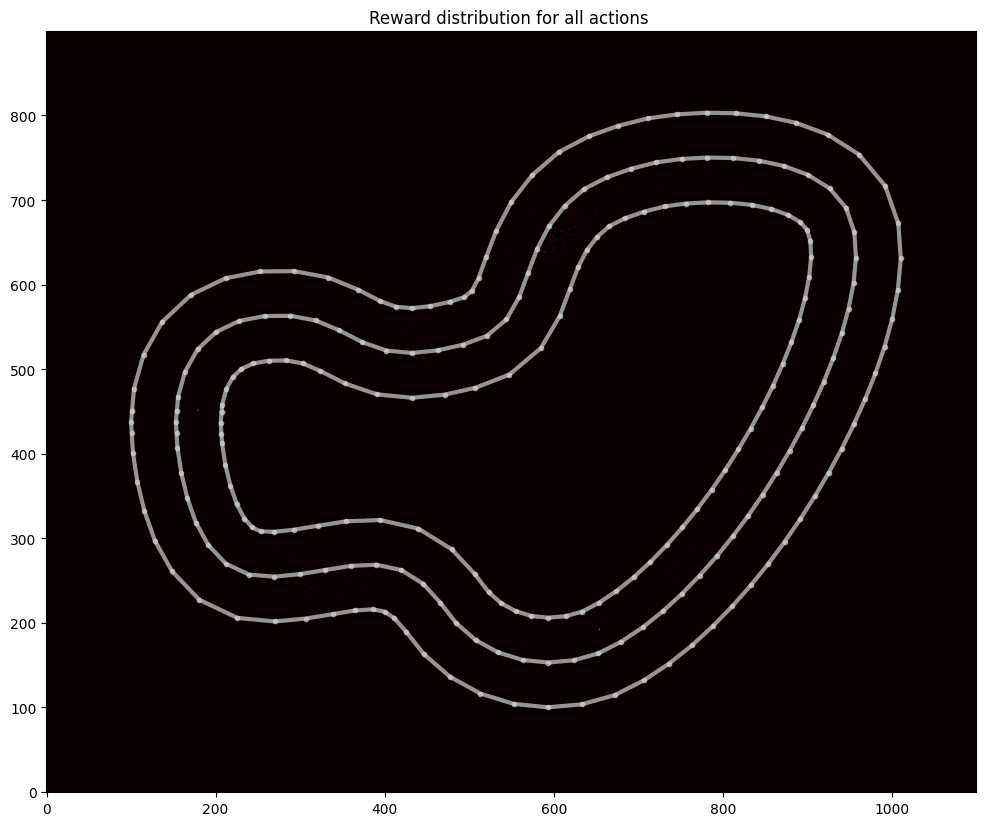

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 15: steering: 0.0, throttle: 2.5


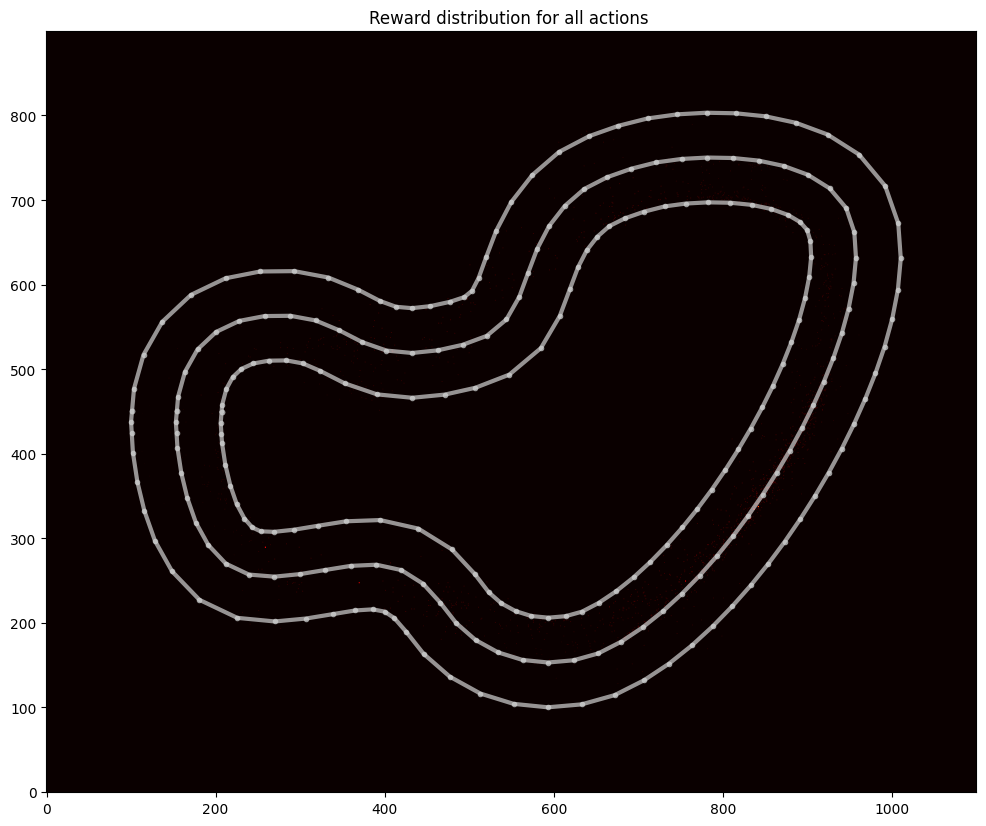

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 16: steering: 0.0, throttle: 1.8


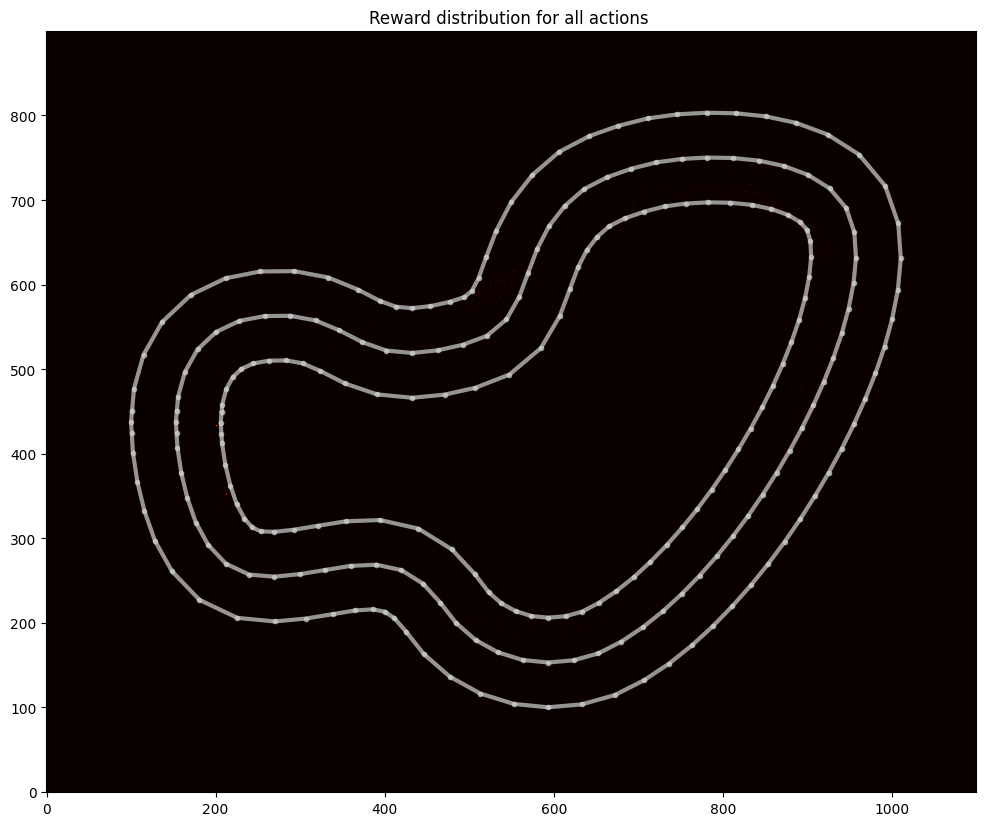

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 17: steering: 8.0, throttle: 3.9


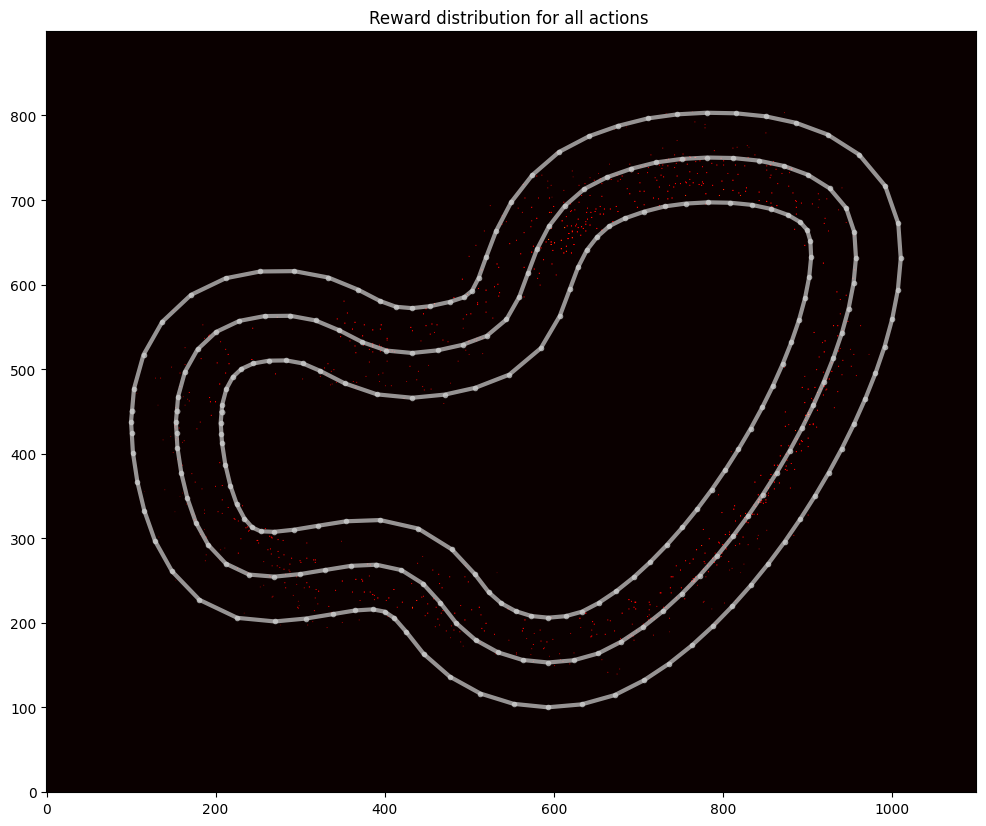

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 18: steering: 8.0, throttle: 3.2


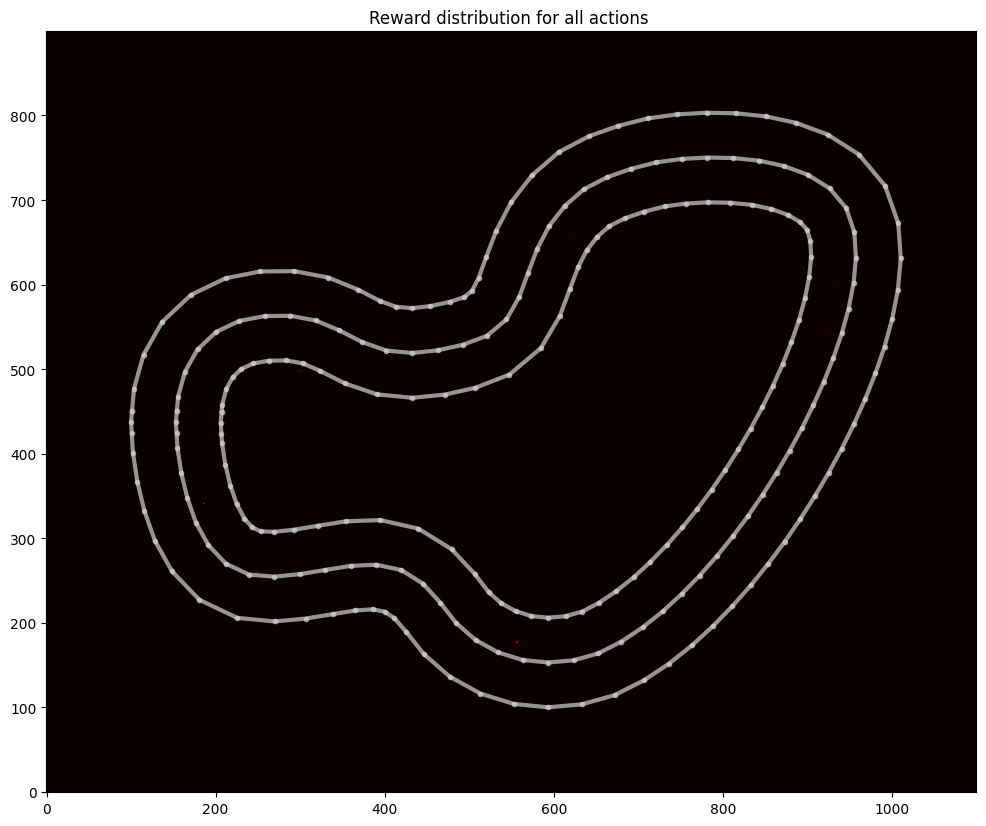

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 19: steering: 8.0, throttle: 2.5


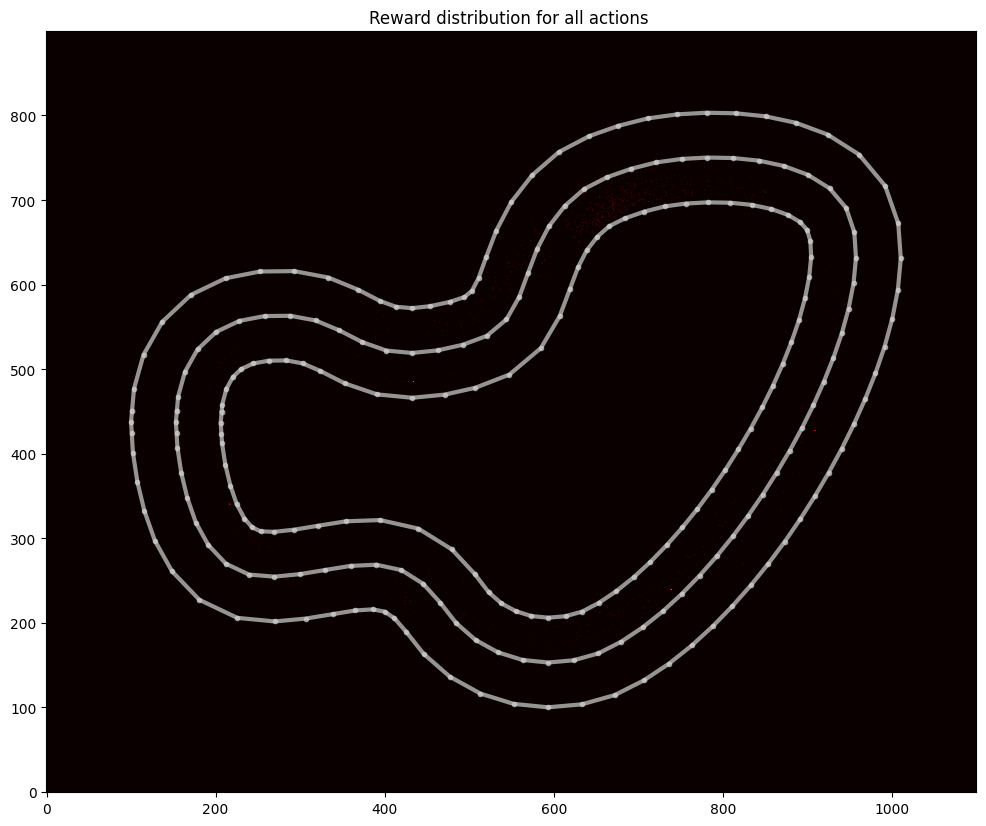

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 20: steering: 8.0, throttle: 1.8


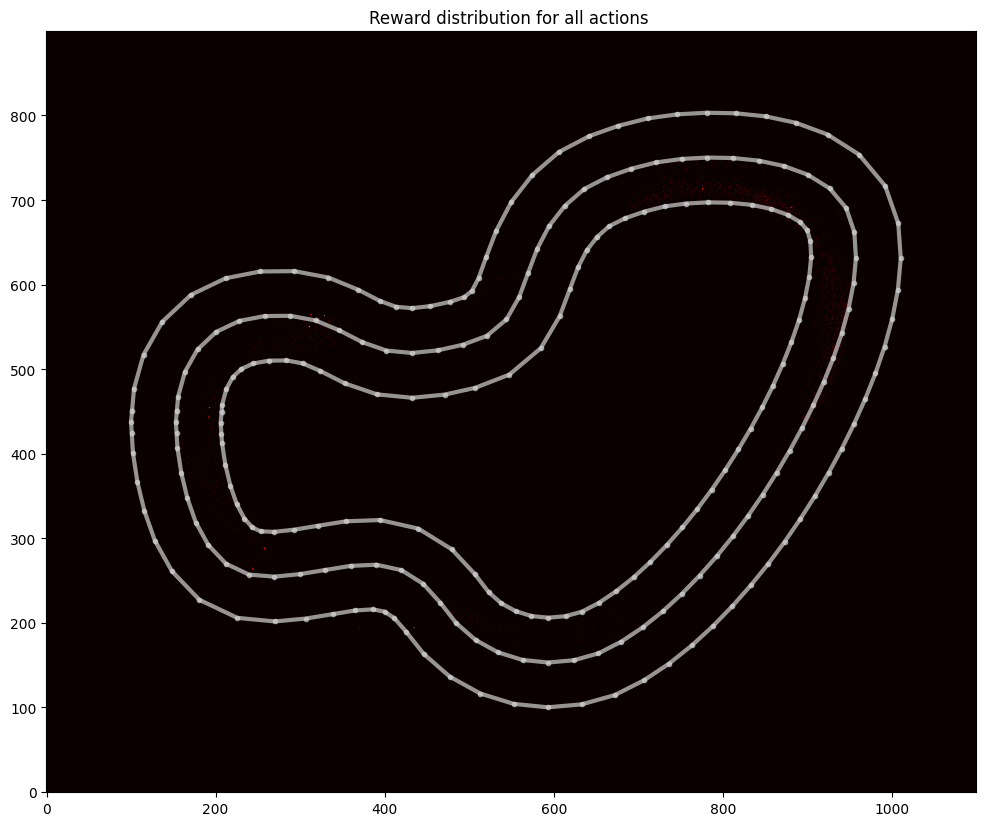

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 21: steering: 8.0, throttle: 1.1


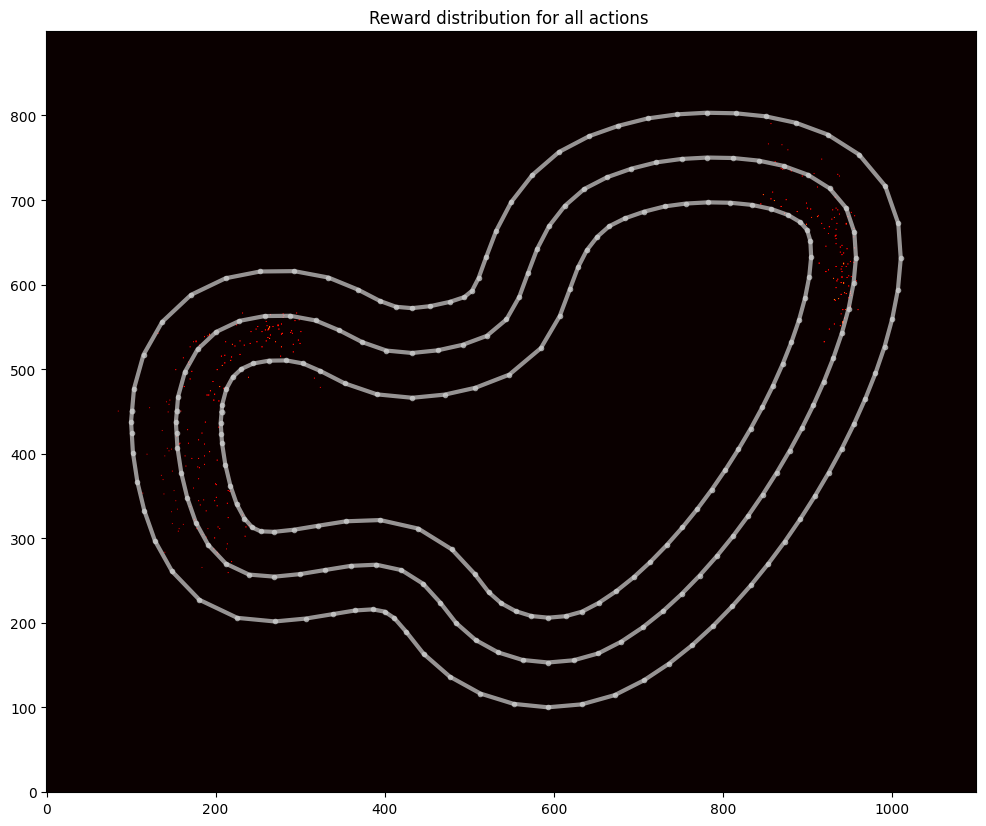

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 22: steering: 16.0, throttle: 3.2


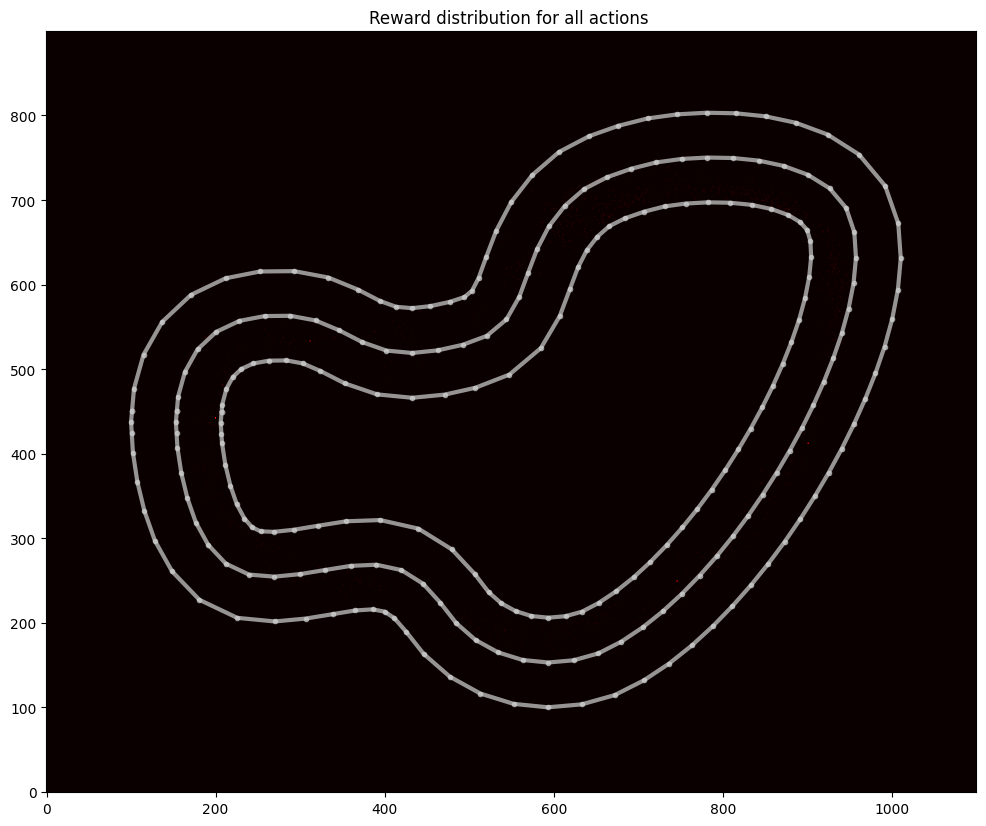

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 23: steering: 16.0, throttle: 2.5


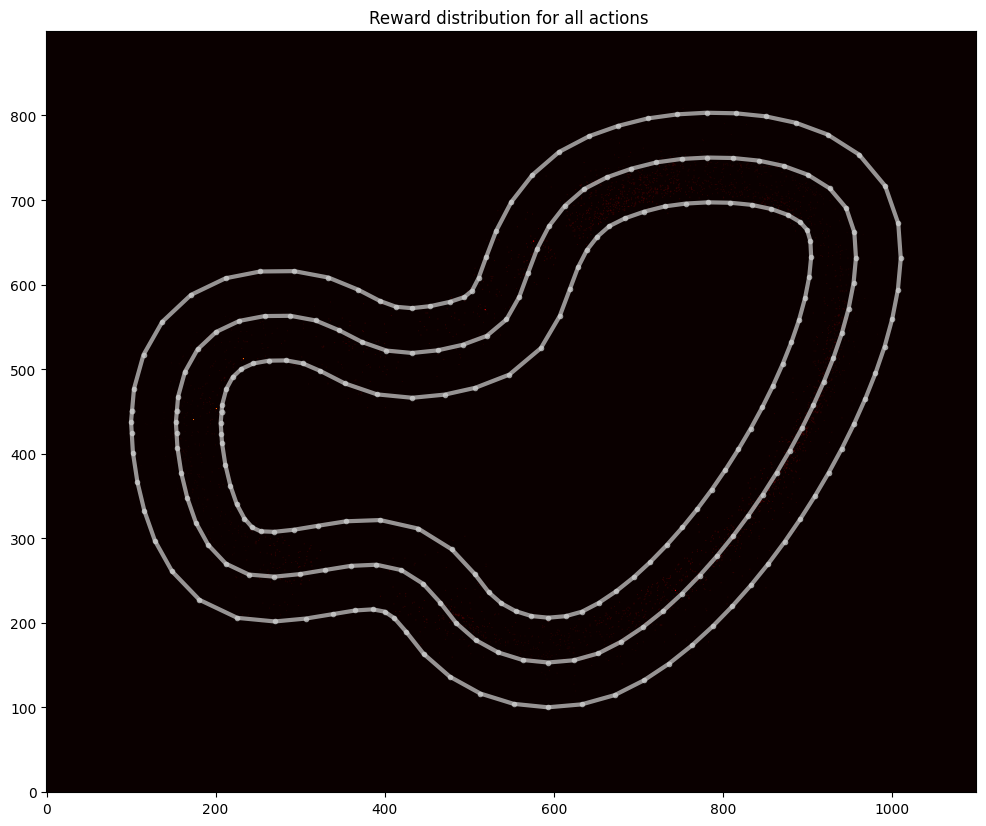

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 24: steering: 16.0, throttle: 1.8


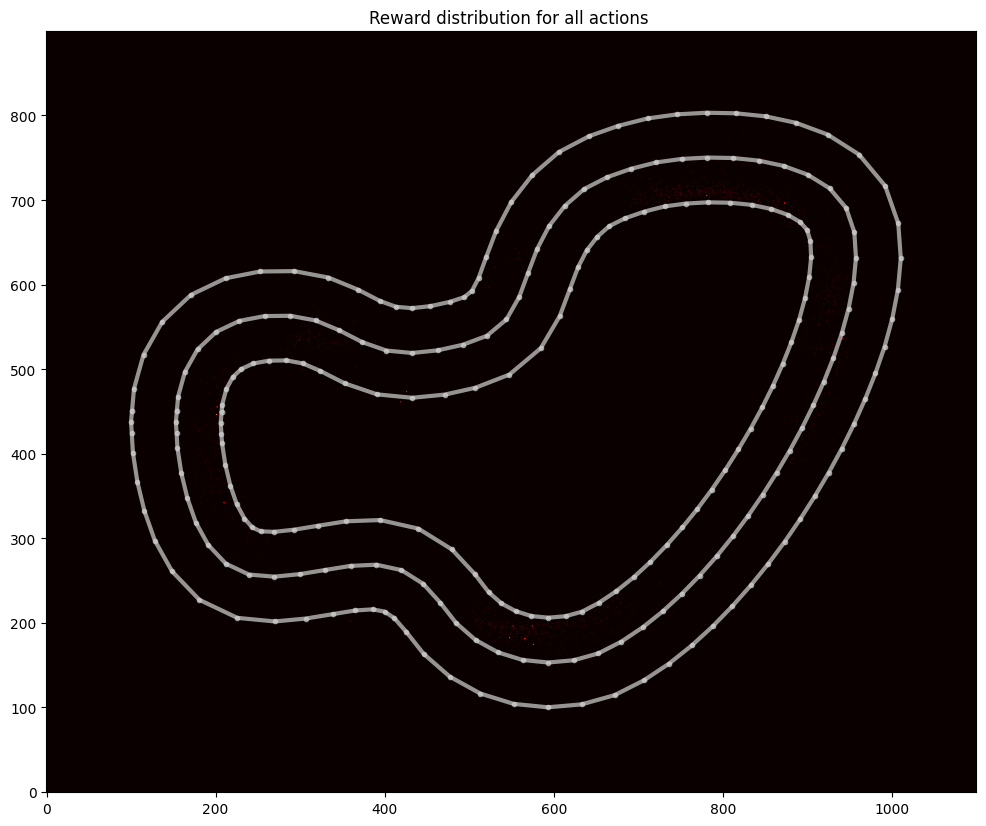

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 25: steering: 16.0, throttle: 1.1


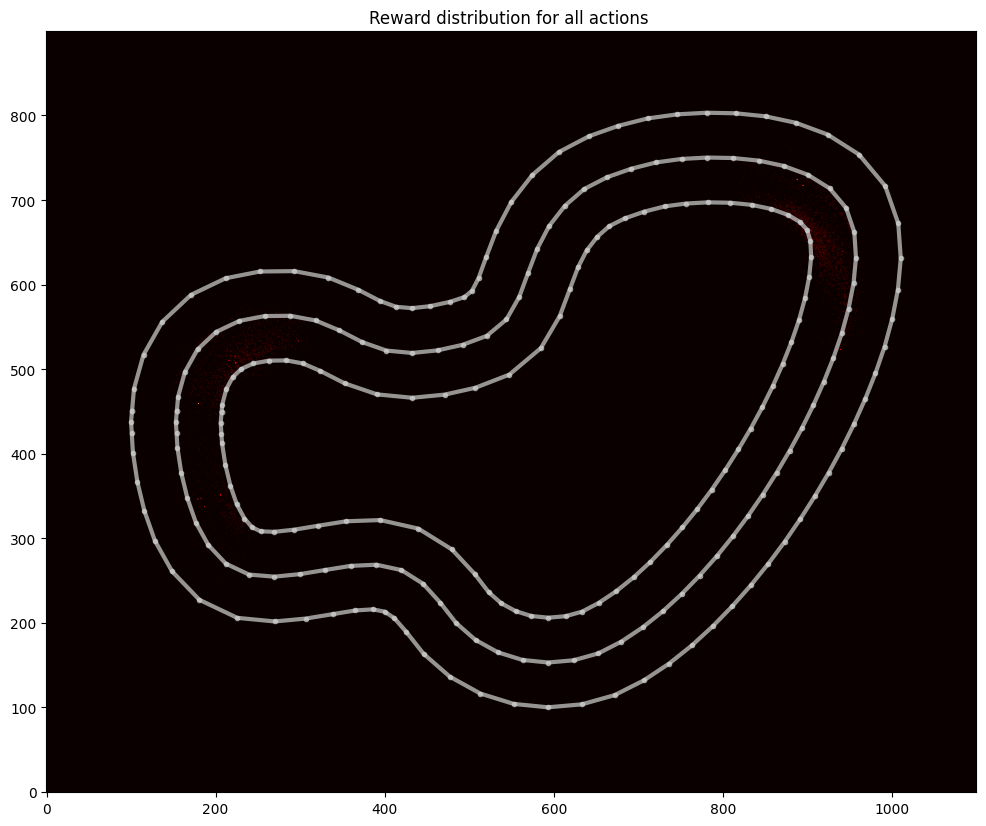

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 26: steering: 24.0, throttle: 2.5


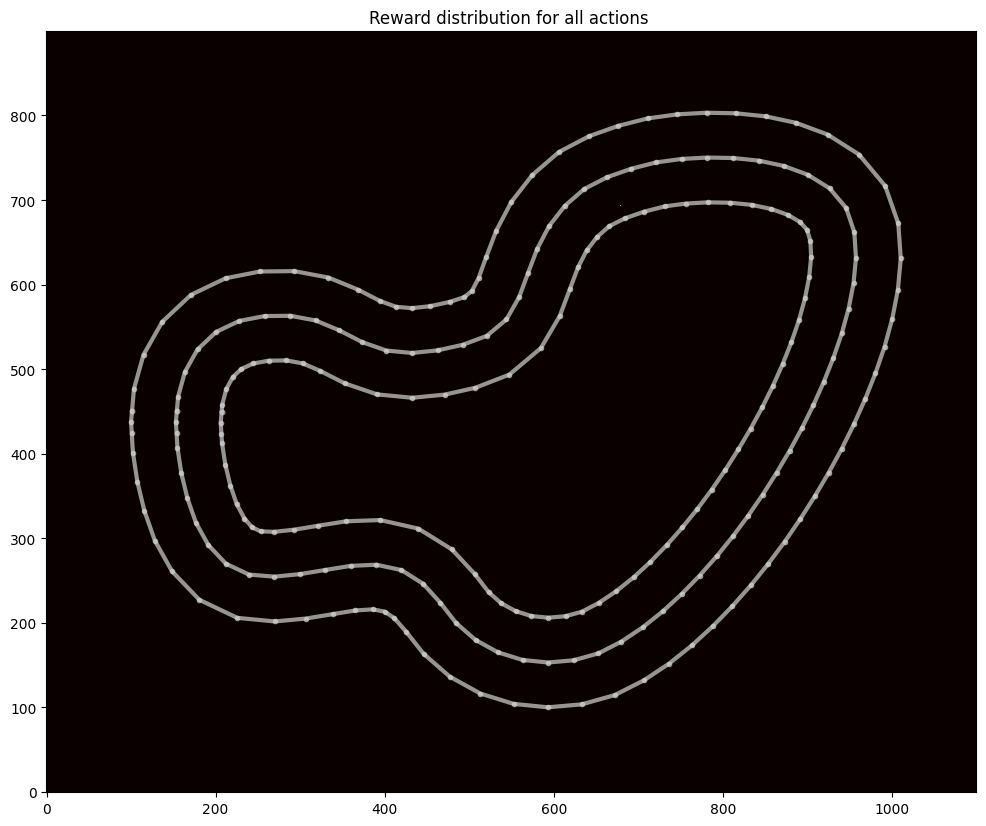

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 27: steering: 24.0, throttle: 1.8


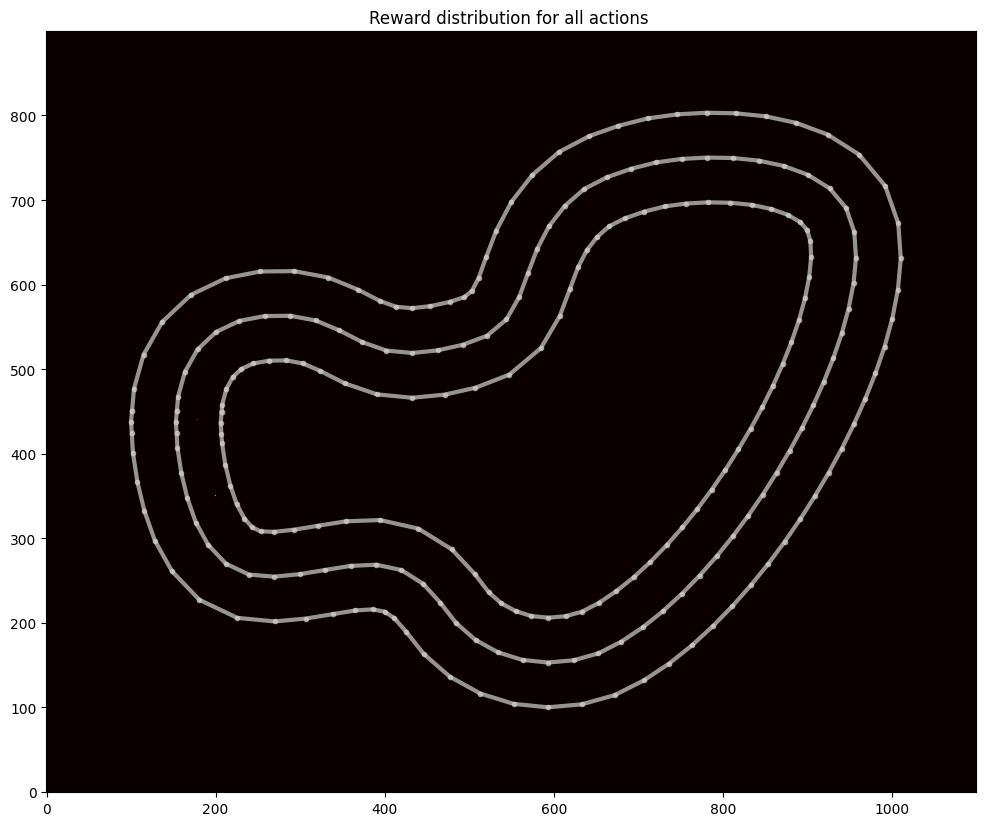

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 28: steering: 24.0, throttle: 1.1


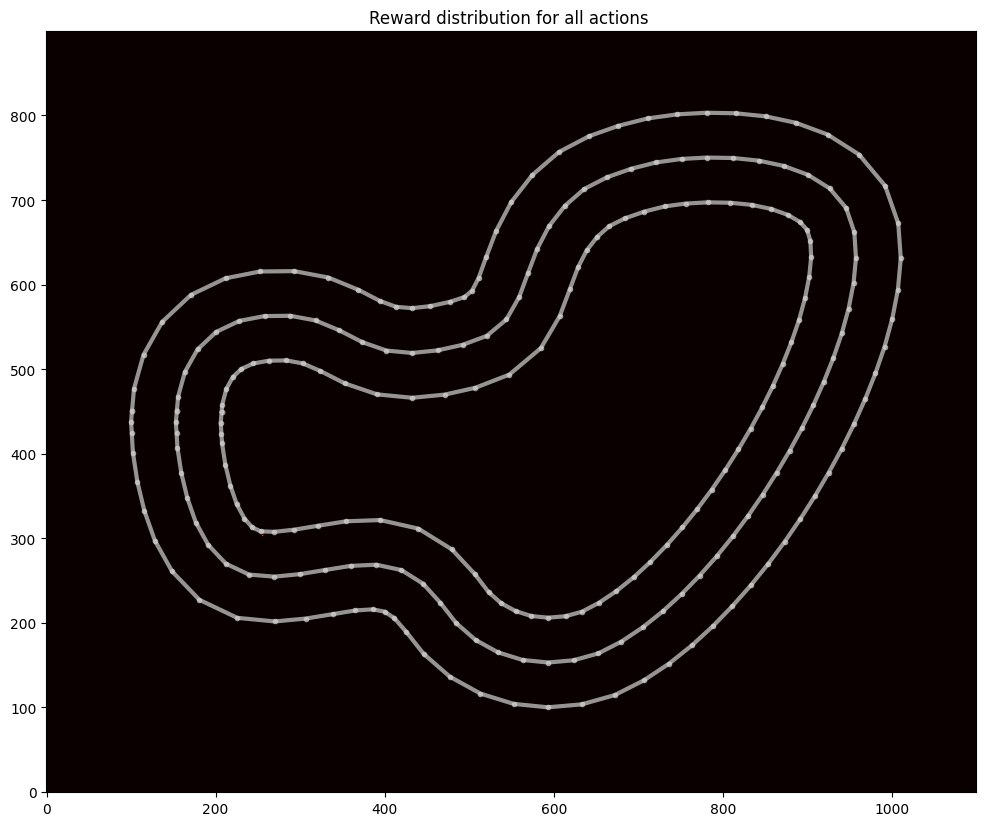

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 29: steering: 30.0, throttle: 1.1


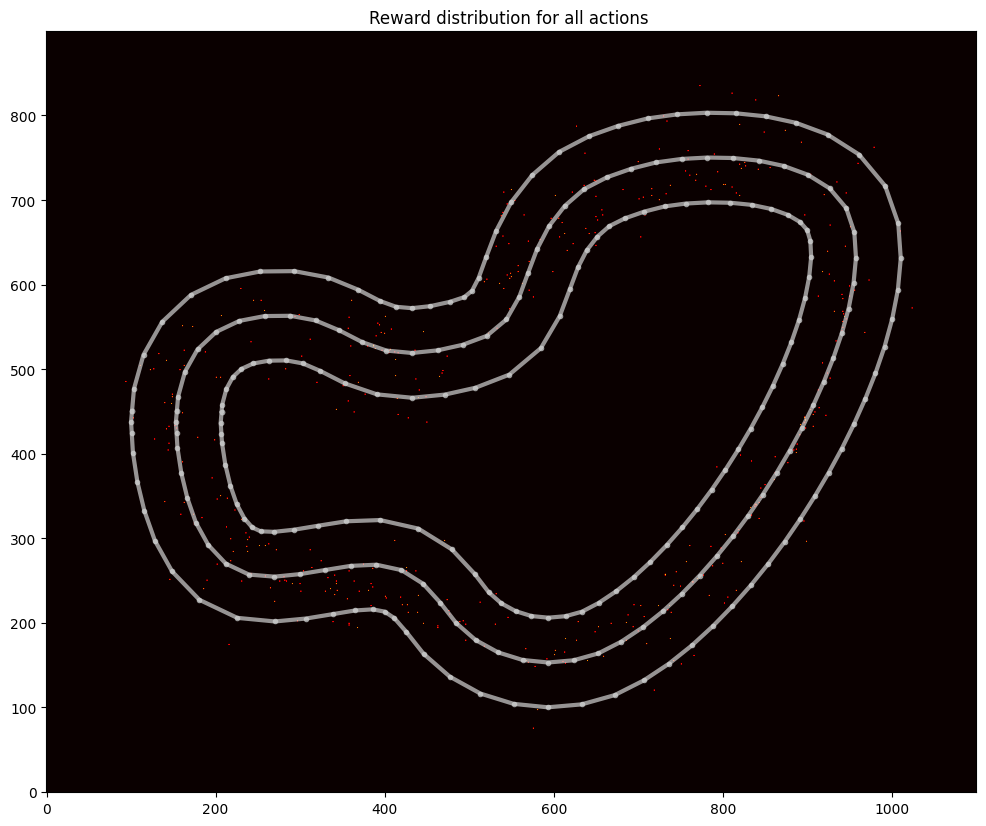

<Figure size 640x480 with 0 Axes>

In [30]:
aslNum = len(asl)
setActions = range(aslNum)  # show graphs for all Actions
# setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions:
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer, a.throttle))
    tr_plot = pu.plot_track(df[df["action"] == a.index], track, value_field="reward")
    plt.show()